In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [2]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

### Load receptive fields

In [3]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_new_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [25]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

#### Load the other horizontal/amacrine cells from David's data on the server

In [26]:
data_dir = os.path.expanduser('~/data/kastner/')
# the late 2012 (after April) have 0.022 mm spatial spacing,
# whereas the ones before have a 0.025 mm spatial spacing
# (for the interneurons)
h_file = 'horizontals_late_2012.h5'
a_file = 'amacrines_late_2012.h5'

interneuron_spacing = 22.0/1000. # in mm

with h5py.File(data_dir + h_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        rf = np.array(f['lines/rfs/%s' %expt])        
        pca = PCA(n_components=2)
        pca.fit(rf)
        
        # Get 1d rf
        g_pca = pca.components_[0]
        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        rf_1d = sign_of_pc * g_pca
        
        # Find space and interpolate the 1d rf
        this_space = get_space(rf_1d, interneuron_spacing, microns_per_degree, in_degrees=True, kind='peak')
        this_cell_interp = interp1d(this_space, rf_1d, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields['horizontal'].append(this_cell_interp(space))


with h5py.File(data_dir + a_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        rf = np.array(f['lines/rfs/%s' %expt])        
        pca = PCA(n_components=2)
        pca.fit(rf)
        
        # Get 1d rf
        g_pca = pca.components_[0]
        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        rf_1d = sign_of_pc * g_pca
        
        # Find space and interpolate the 1d rf
        this_space = get_space(rf_1d, interneuron_spacing, microns_per_degree, in_degrees=True, kind='peak')
        this_cell_interp = interp1d(this_space, rf_1d, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields['amacrine'].append(this_cell_interp(space))

7it [00:00, 382.72it/s]
22it [00:00, 414.61it/s]


### Compute receptive field components (RF convolved with Transmission Filter)

In [33]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [34]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

In [201]:
space_constant = {
    'horizontal': 118./microns_per_degree,
    'amacrine': 78./microns_per_degree
    }

conv_mode = 'full'

rf_components = collections.defaultdict(list)
for interneuron_type in receptive_fields.keys():
    if interneuron_type in ['horizontal', 'amacrine']:
        for rf in receptive_fields[interneuron_type]:
            proj_range = [np.exp(-abs(t)/space_constant[interneuron_type]) for t in np.linspace(np.min(space),
                                                                                        np.max(space),len(space))]
            proj_field = np.convolve(proj_range, rf, mode=conv_mode)
            proj_field *= np.mean(rf) / np.mean(proj_field)

            proj_space = get_space(proj_field, np.diff(space[:2]), microns_per_degree, in_degrees=False)
            component_interp = interp1d(proj_space, proj_field, kind='slinear', bounds_error=False, fill_value=[0])
            rf_components[interneuron_type].append(component_interp(space))
        
interneuron_fits = collections.defaultdict(list)
for interneuron_type in rf_components.keys():
    for component in rf_components[interneuron_type]:
        popt, pcov = curve_fit(gaussian, space, -component, p0=[2.5, 0.0, 2.1])
        interneuron_fits[interneuron_type].append(abs(popt[0]))

# Figure 2 A, B

In [171]:
common_x_start = -1.25
common_x_end = 1.25

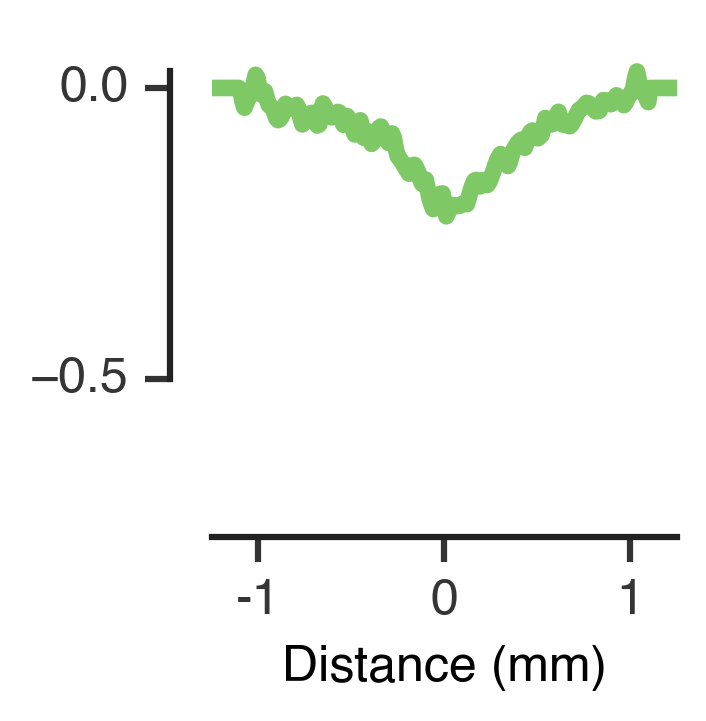

In [172]:
# going to convert space in degrees to mm
# so space * microns/degree * mm/microns
fig = plt.gcf()
fig.set_size_inches((2,2))
plt.plot(space * microns_per_degree / 1000., receptive_fields['horizontal'][1], color='#47B224', 
         alpha=0.7, linewidth=4)

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(minorLocator)
# ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-.7, 0.1)
plt.xlim(common_x_start, common_x_end)
plt.xlabel('Distance (mm)')
adjust_spines(plt.gca())

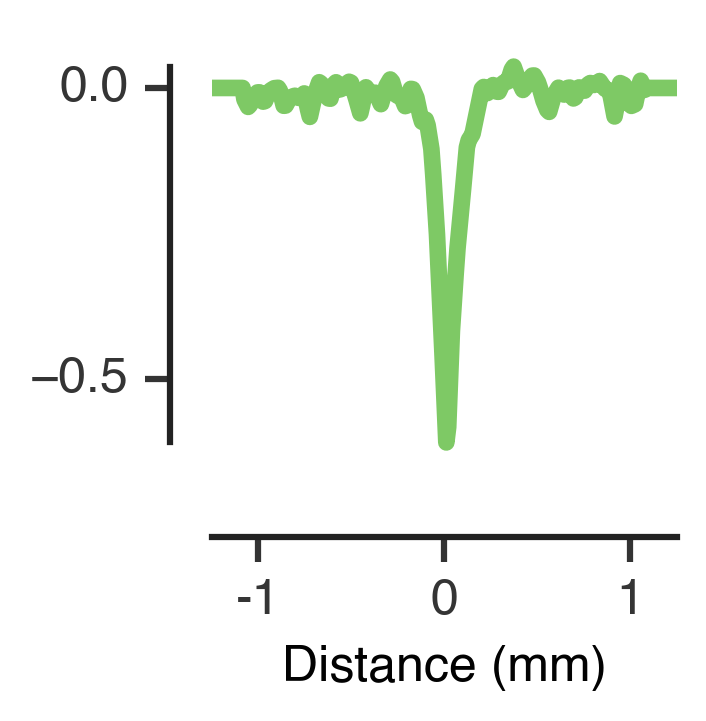

In [173]:
# going to convert space in degrees to mm
# so space * microns/degree * mm/microns
fig = plt.gcf()
fig.set_size_inches((2,2))
plt.plot(space * microns_per_degree / 1000., receptive_fields['amacrine'][0], color='#47B224', 
         alpha=0.7, linewidth=4)

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(minorLocator)
# ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-.7, 0.1)
plt.xlim(common_x_start, common_x_end)
plt.xlabel('Distance (mm)')
adjust_spines(plt.gca())

## Mean amacrine & horizontal RFs

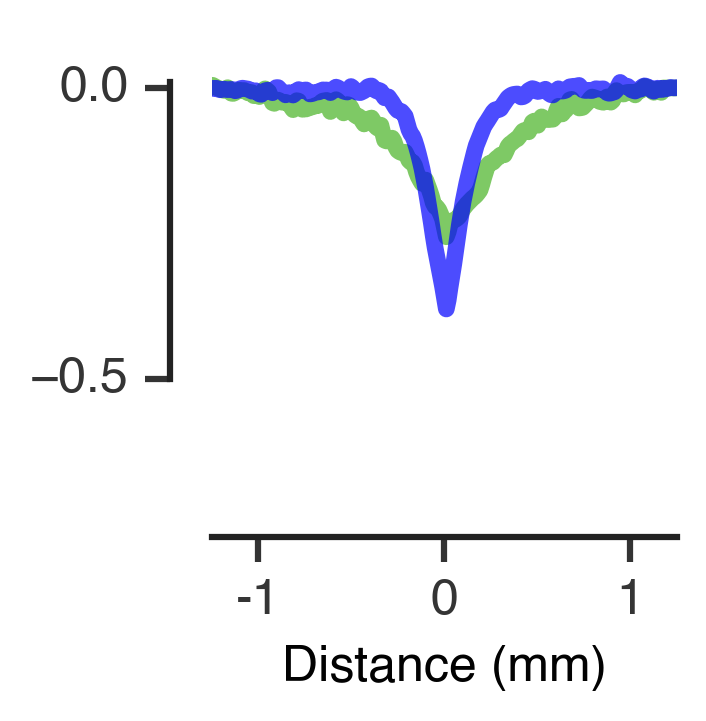

In [174]:
# going to convert space in degrees to mm
# so space * microns/degree * mm/microns
fig = plt.gcf()
fig.set_size_inches((2,2))
plt.plot(space * microns_per_degree / 1000., np.mean(receptive_fields['horizontal'], axis=0), color='#47B224', 
         alpha=0.7, linewidth=4)
plt.plot(space * microns_per_degree / 1000., np.mean(receptive_fields['amacrine'], axis=0), color='#0000FE', 
         alpha=0.7, linewidth=4)

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(minorLocator)
# ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-.7, 0.1)
plt.xlim(common_x_start, common_x_end)
plt.xlabel('Distance (mm)')
adjust_spines(plt.gca())

# Figure 2 E, F

Previously as the horizontal component I was using the average horizontal component from the 2 horizontal cells that David gave me originally. Let's use the average of all the horizontal cells now.

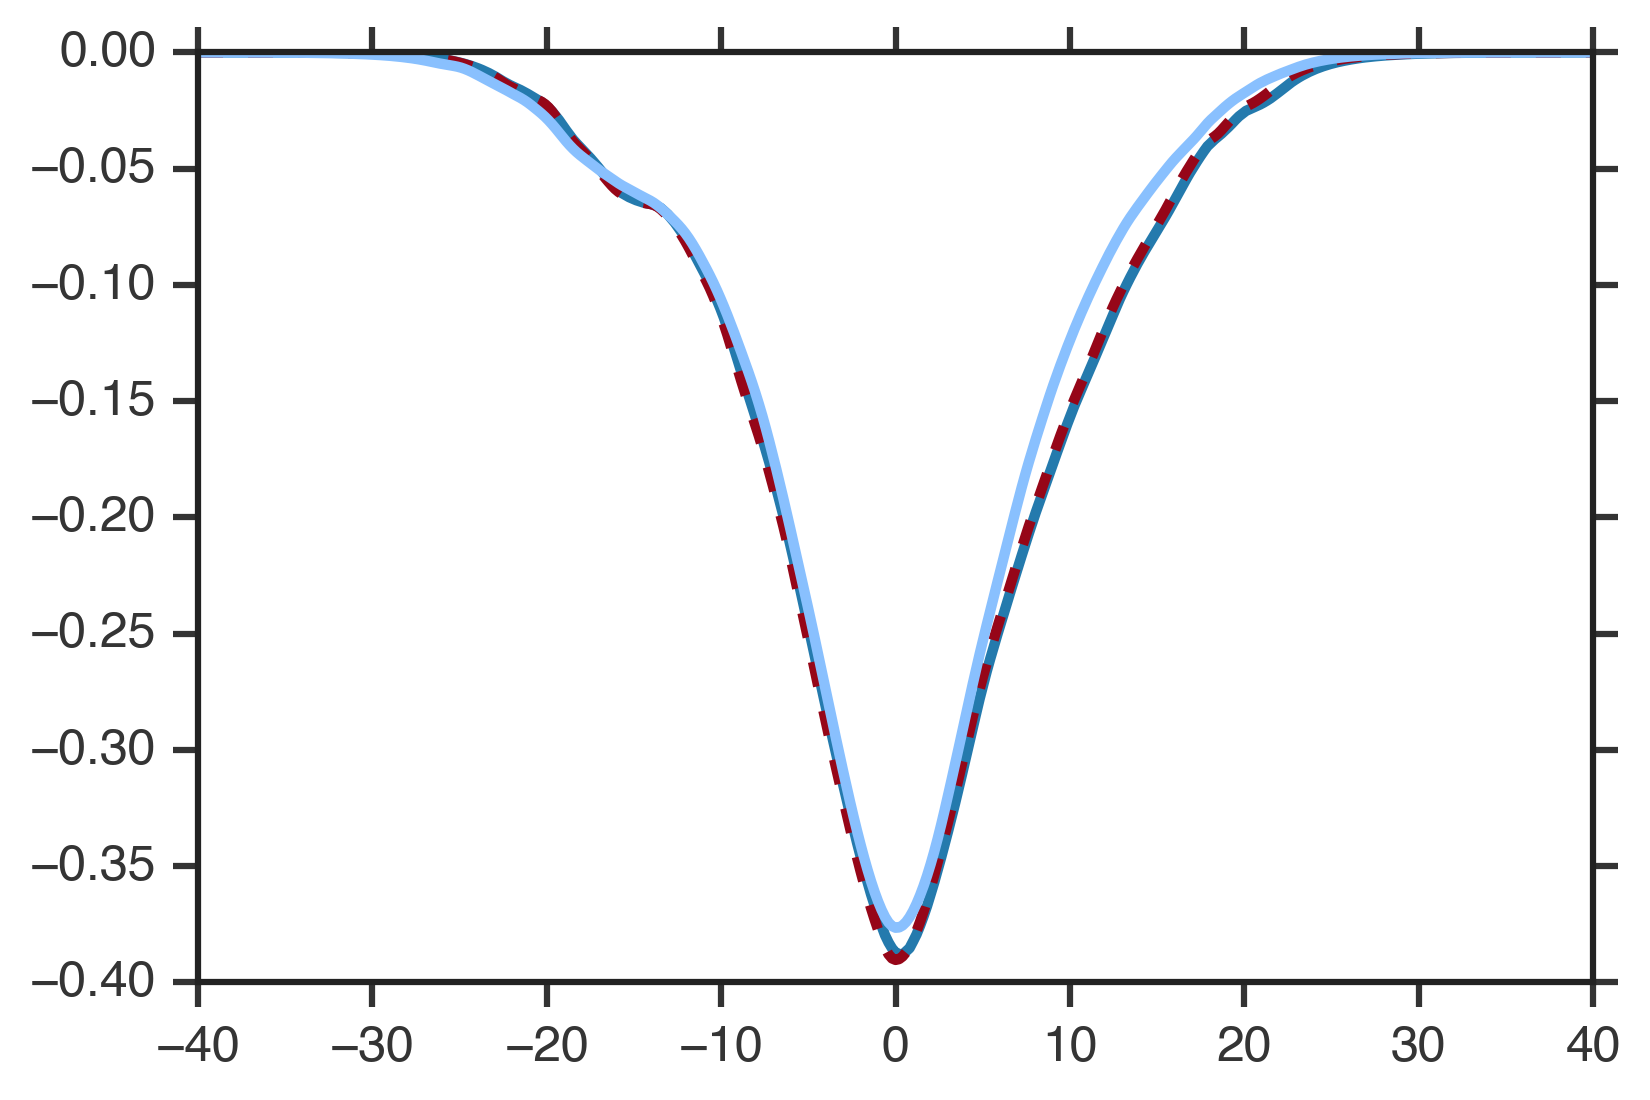

In [86]:
plt.plot(space, horz_pf)
plt.plot(space, np.mean([rf_components['horizontal'][0], rf_components['horizontal'][1]], axis=0), '--')
plt.plot(space, np.mean(rf_components['horizontal'], axis=0), color='#89C0FE')

Same thing for amacrine cell contribution

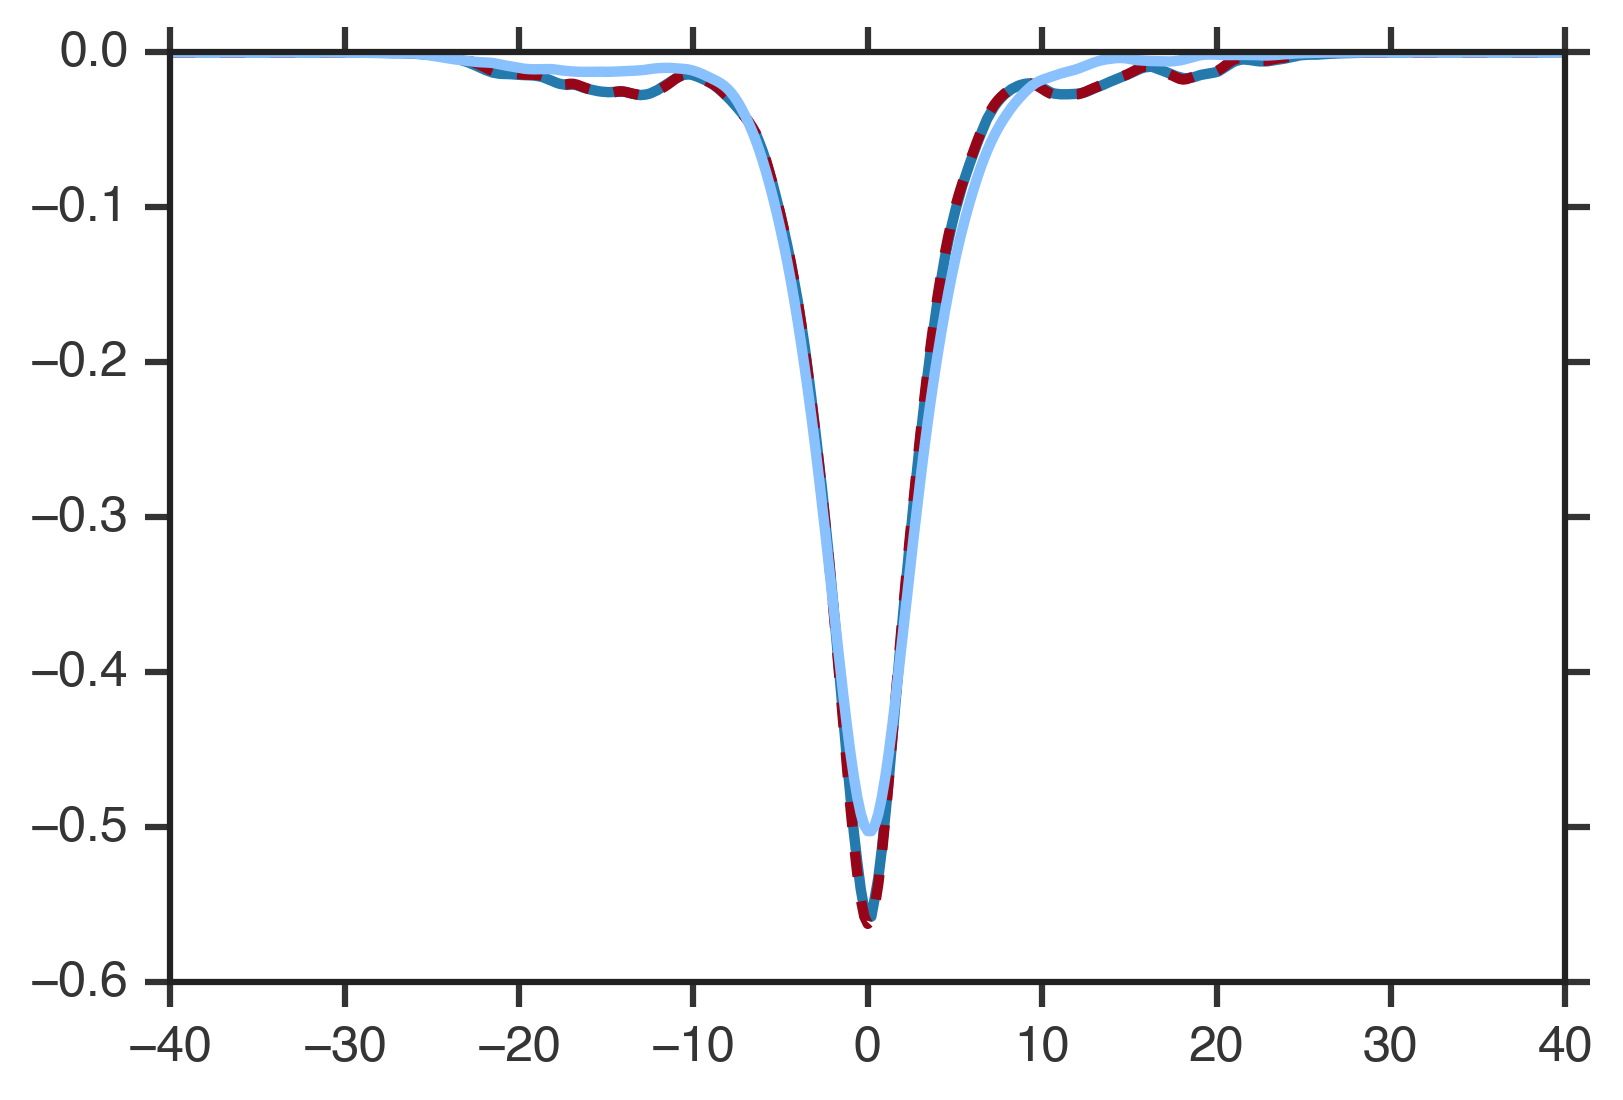

In [89]:
plt.plot(space, ama_pf)
plt.plot(space, np.mean([rf_components['amacrine'][0], rf_components['amacrine'][1]], axis=0), '--')
plt.plot(space, np.mean(rf_components['amacrine'], axis=0), color='#89C0FE')

## For the ganglion cell surround, let's use the horizontal + amacrine cell component fit from the linear model we use later on

### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [90]:
old_horz_pf = horz_pf.copy()
old_ama_pf = ama_pf.copy()

horz_pf = np.mean(rf_components['horizontal'], axis=0)
ama_pf = np.mean(rf_components['amacrine'], axis=0)

horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

### Get center widths for each ganglion cell

In [91]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [92]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [94]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

celltype = 'ganglion'        
for idg, g in tqdm(enumerate(receptive_fields[celltype])):
    try:
        popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
        center_id = np.argmin(abs(popt_this[:2]))
        surround_id = 1 ^ center_id
        center_widths[celltype].append(abs(popt_this[center_id]))
        surround_widths[celltype].append(abs(popt_this[surround_id]))
        center_strengths[celltype].append(popt_this[center_id+2])
        surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
    except:
        fit_failures[celltype].append(idg)

        # just set params to median across cells
        # this way the params are still aligned with the receptive field id
        center_widths[celltype].append(np.median(center_widths[celltype]))
        surround_widths[celltype].append(np.median(surround_widths[celltype]))
        center_strengths[celltype].append(np.median(center_strengths[celltype]))
        surround_strengths[celltype].append(np.median(surround_strengths[celltype]))

        print("Couldn't fit cell %d" %idg)

14it [00:03,  1.58it/s]

Couldn't fit cell 13
Couldn't fit cell 14

19it [00:05,  2.19it/s]


Couldn't fit cell 20

29it [00:08,  5.28it/s]


Couldn't fit cell 29

60it [00:13,  4.48it/s]

Plot the average profile across celltypes

In [102]:
cws = np.array(center_widths[celltype])
sws = np.array(surround_widths[celltype])
css = np.array(center_strengths[celltype])
sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
median_center_width = np.median(abs(cws))
median_surround_width = np.median(abs(sws))
median_center_strength = np.median(-abs(css))
median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [104]:
median_center_width

1.5412227043448907

In [105]:
median_surround_width

7.4512765078172301

Bar charts to visualize diversity

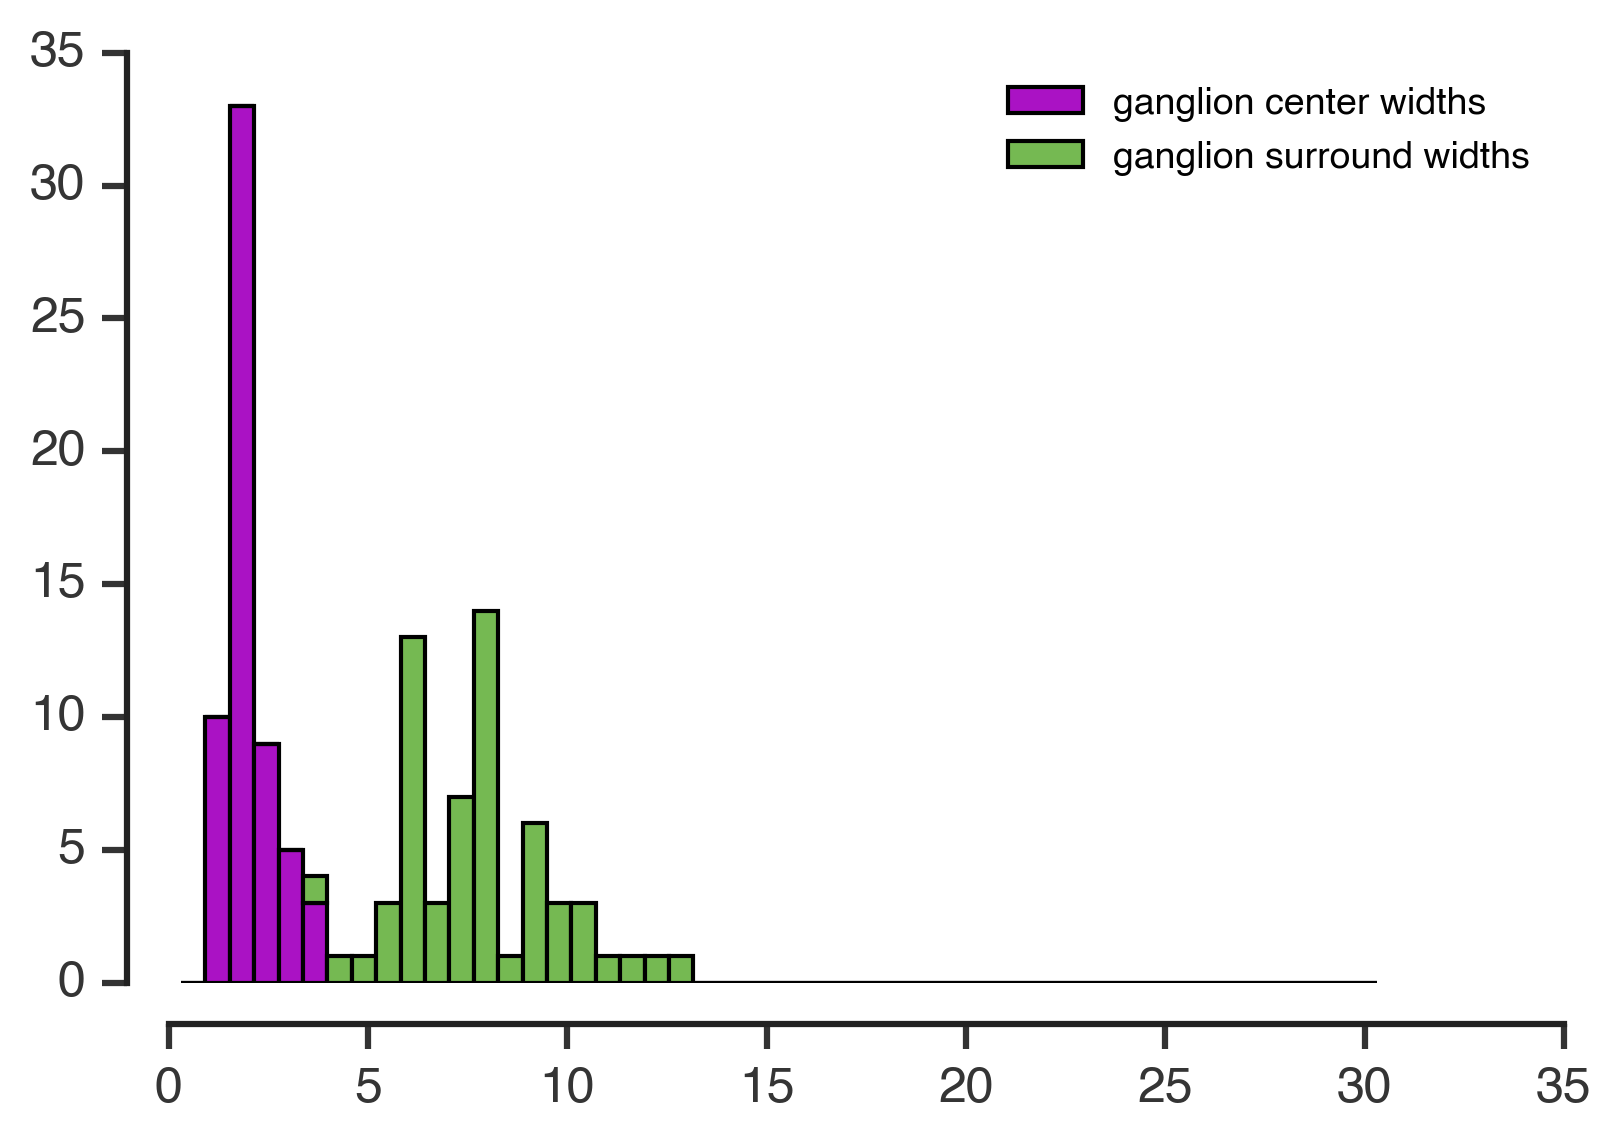

In [107]:
cws = np.array(center_widths[celltype])
sws = np.array(surround_widths[celltype])
# bins = np.linspace(np.min([cws]), np.max(sws[sws < 200]), 50)
bins = np.linspace(0,30,50)
counts, bins = np.histogram(cws[cws < 500], bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s center widths' %celltype)

counts_surr, bins_surr = np.histogram(sws[sws < 500], bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts_surr, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s surround widths' %celltype, bottom=counts)

adjust_spines(plt.gca())
plt.legend(frameon=False, fontsize=9)

### Now use this center width to fit the full model to each ganglion cell

In [159]:
iterations = 100

fits = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)
surrounds = collections.defaultdict(list)
normed_rfs = collections.defaultdict(list)
                
popts = []

for i,rf in tqdm(enumerate(receptive_fields[celltype])):
    center = gaussian(x=space, sigma=center_widths[celltype][i], mu=0.)
    center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

    def rf_model(horz_weight, center_weight):
        horz_weight = np.min([1.0, abs(horz_weight)])
        center_weight = np.min([1.0, abs(center_weight)])
        return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
    
    def surround(horz_weight, center_weight):
        horz_weight = np.min([1.0, abs(horz_weight)])
        center_weight = np.min([1.0, abs(center_weight)])
        return (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

    def model_error_to_ganglion_cells(weights):
        hw, cw = weights
        modeled_rf = rf_model(hw, cw)
        normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
        return sum(abs(normed_rf - rf))

    best_fit_err = np.inf
    for itr in range(iterations):
        this_popt = minimize(model_error_to_ganglion_cells, np.random.rand(2))
        if this_popt.fun < best_fit_err:
            best_fit_err = this_popt.fun
            popt = this_popt

    # get mean squared error
    modeled_rf = rf_model(*popt.x)
    normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
    mse = np.mean((normed_rf - rf)**2)

    # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
    hw = np.min([1.0, abs(popt.x[0])])
    cw = np.min([1.0, abs(popt.x[1])])

    popts.append(np.array([hw, cw]))
    abs_errors[celltype].append(popt.fun)
    mean_squared_errors[celltype].append(mse)
    variances[celltype].append(np.var(rf))
    surrounds[celltype].append(surround(hw, cw))
    normed_rfs[celltype].append(normed_rf)

fits[celltype] = np.stack(popts)

60it [01:04,  1.02it/s]


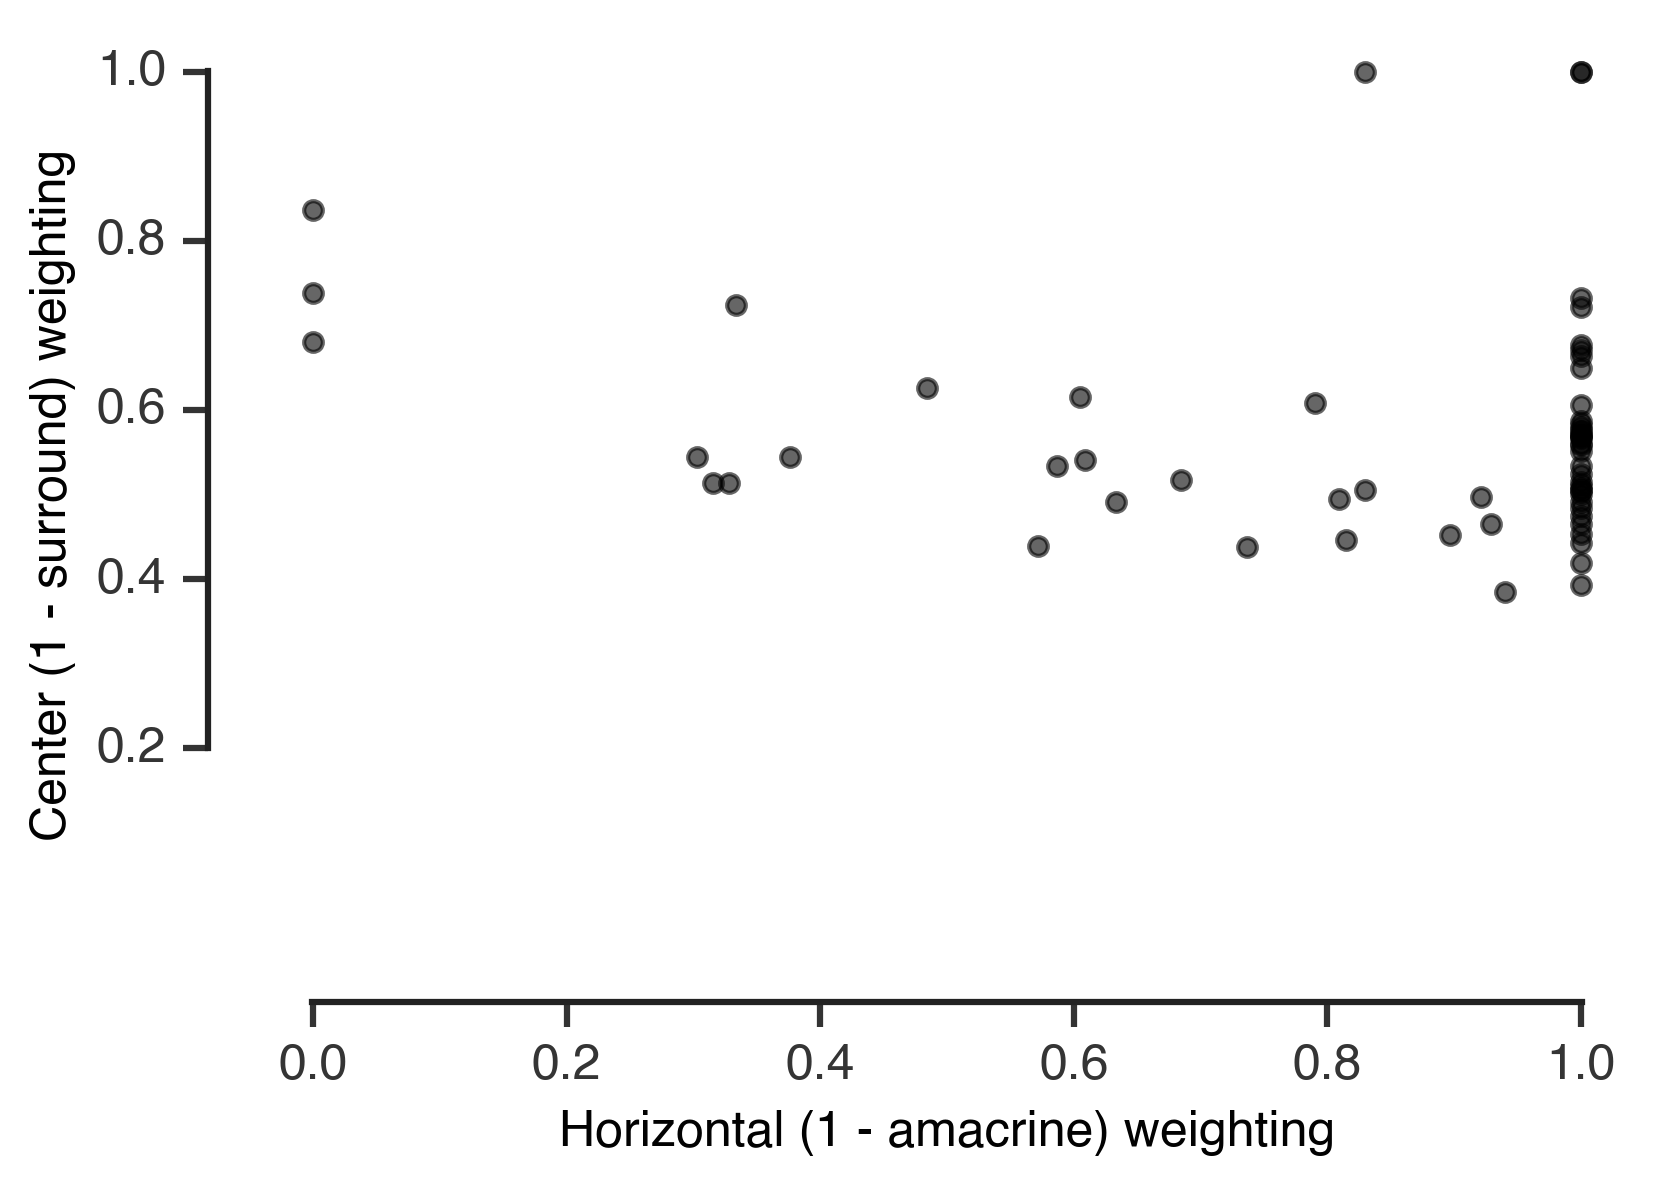

In [162]:
plt.scatter(fits[celltype][:,0], fits[celltype][:,1], c='k', alpha=0.6)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
adjust_spines(plt.gca())
plt.xlabel('Horizontal (1 - amacrine) weighting')
plt.ylabel('Center (1 - surround) weighting')

In [120]:
fits['ganglion'][:,1]

array([ 0.56779804,  0.60680593,  0.4845287 ,  0.58291208,  0.54512563,
        0.46504387,  0.55972597,  0.44244475,  0.46550539,  0.49193963,
        0.67667076,  0.66469269,  0.61599301,  1.        ,  1.        ,
        0.83663772,  0.7389205 ,  0.73333185,  0.68075071,  0.72507268,
        1.        ,  0.53437213,  0.45261305,  0.50617107,  0.72222401,
        0.47500928,  0.49457837,  0.65028992,  0.44003513,  0.50534098,
        0.52507184,  0.49712765,  0.51004646,  0.50088674,  0.51466188,
        0.54531565,  0.55140308,  0.57101943,  0.54089407,  0.44677267,
        0.57767417,  0.50623637,  0.67185076,  0.55896604,  0.51408015,
        0.43849577,  0.62687043,  0.51788053,  0.60845064,  0.51439271,
        0.38491935,  0.41964078,  0.49111686,  0.3935052 ,  0.45392143,
        0.57496699,  0.53370944,  0.58717867,  0.56843914,  0.57076251])

Take a look at the cells identified as monophasic

(-40.0, 40.0, -0.5, 0.10000000000000009)

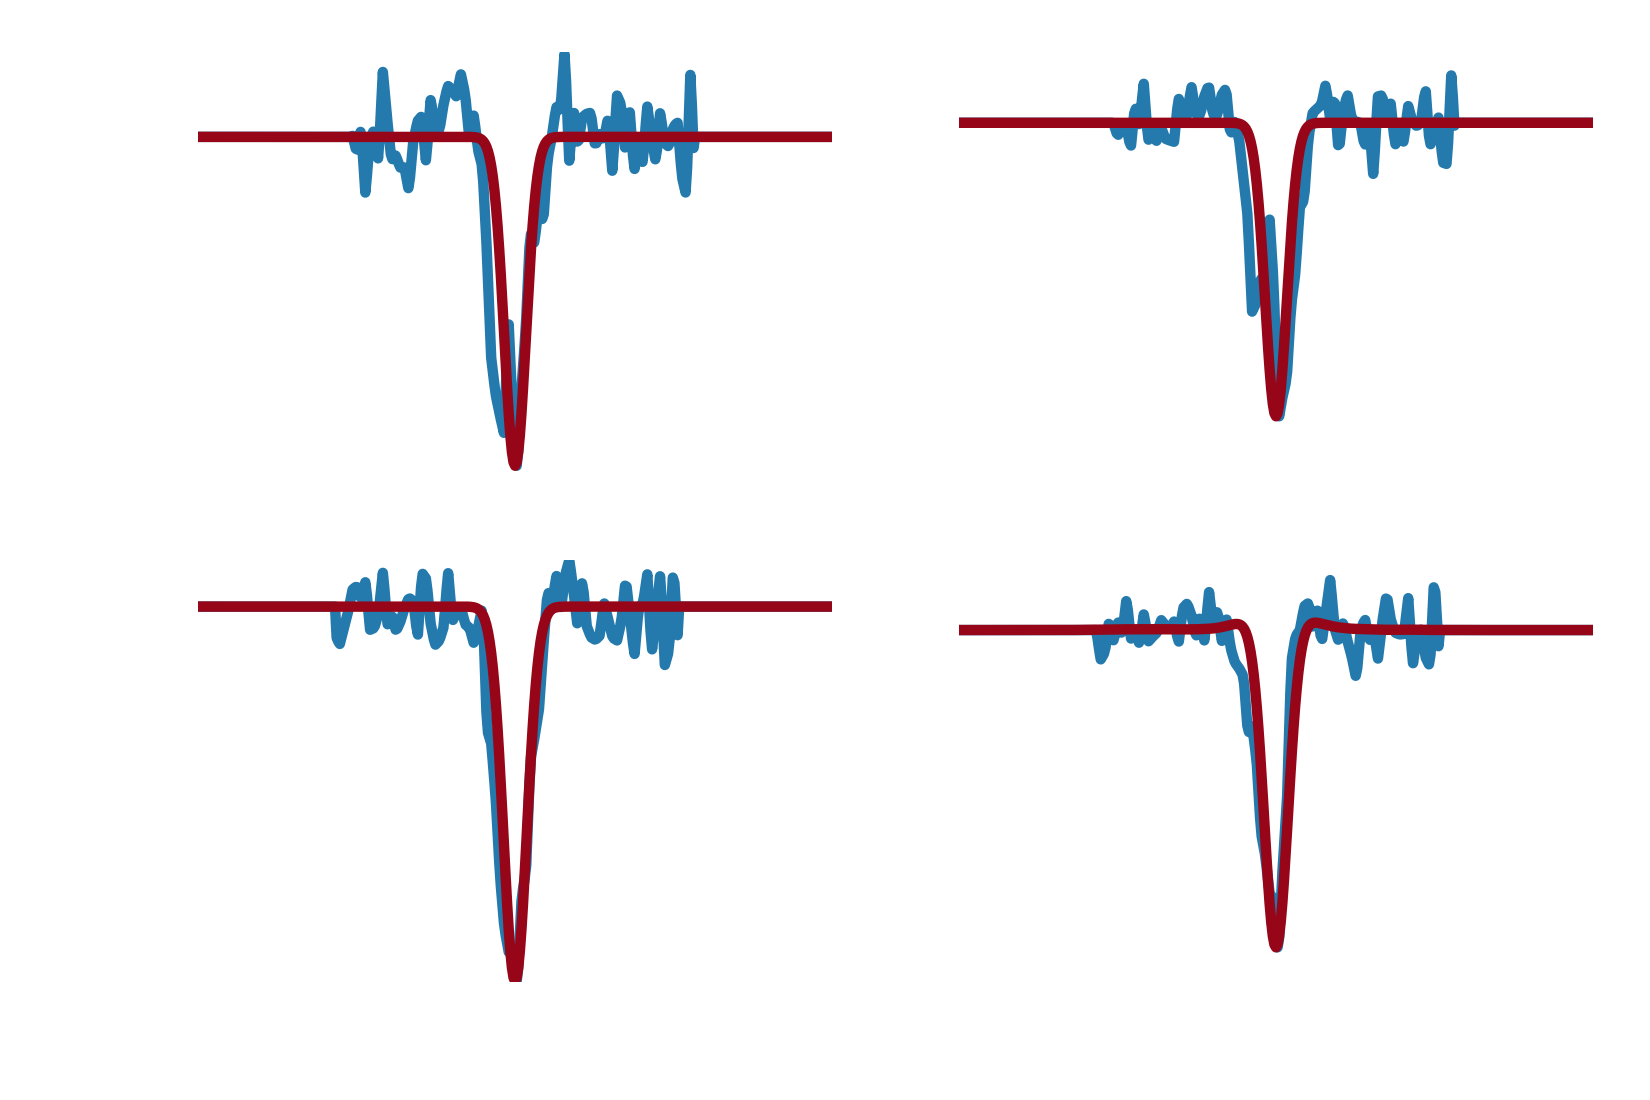

In [132]:
plt.subplot(2,2,1)
plt.plot(space, receptive_fields['ganglion'][13])
plt.plot(space, normed_rfs['ganglion'][13])
# plt.plot(space, surrounds['ganglion'][13])
plt.axis('off')

plt.subplot(2,2,2)
plt.plot(space, receptive_fields['ganglion'][14])
plt.plot(space, normed_rfs['ganglion'][14])
plt.axis('off')

plt.subplot(2,2,3)
plt.plot(space, receptive_fields['ganglion'][20])
plt.plot(space, normed_rfs['ganglion'][20])
plt.axis('off')

plt.subplot(2,2,4)
plt.plot(space, receptive_fields['ganglion'][15])
plt.plot(space, normed_rfs['ganglion'][15])
plt.axis('off')


## Now we can plot the amacrine, horizontal components against the ganglion surround

#### Horizontal

In [150]:
fits['ganglion'][9]

array([ 0.63305318,  0.49193963])

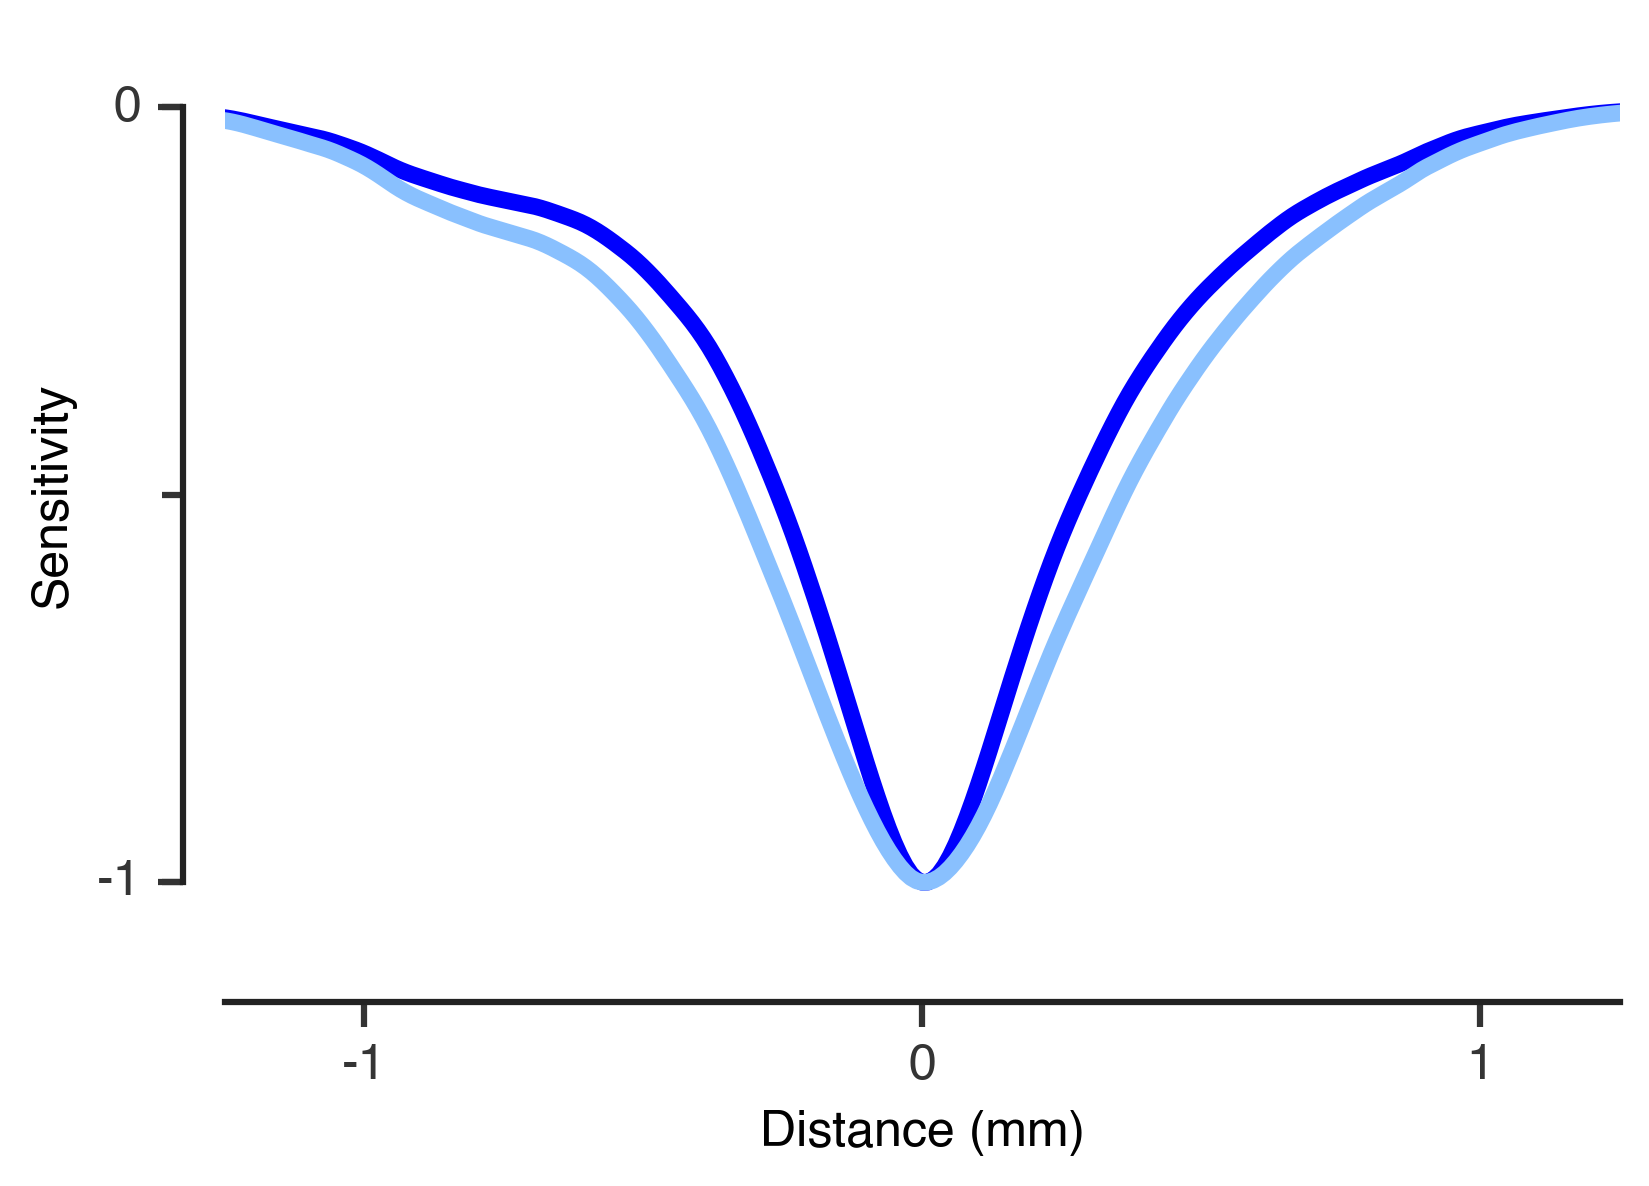

In [175]:
ganglion_surround = np.mean(surrounds['ganglion'], axis=0)
# ganglion_surround = surrounds['ganglion'][9]


plt.plot(space*microns_per_degree/1000., -ganglion_surround/np.max(abs(ganglion_surround)), color='#0000FE', linewidth=4)
plt.plot(space*microns_per_degree/1000., -horz_pf/np.max(abs(horz_pf)), color='#89C0FE', linewidth=4)
# plt.plot(space, ama_surround/np.max(abs(ama_surround)), color='#0000FE', linewidth=4)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-1.1,0.1)
plt.xlim(common_x_start, common_x_end)
plt.xlabel('Distance (mm)')
adjust_spines(plt.gca())

#### Amacrine

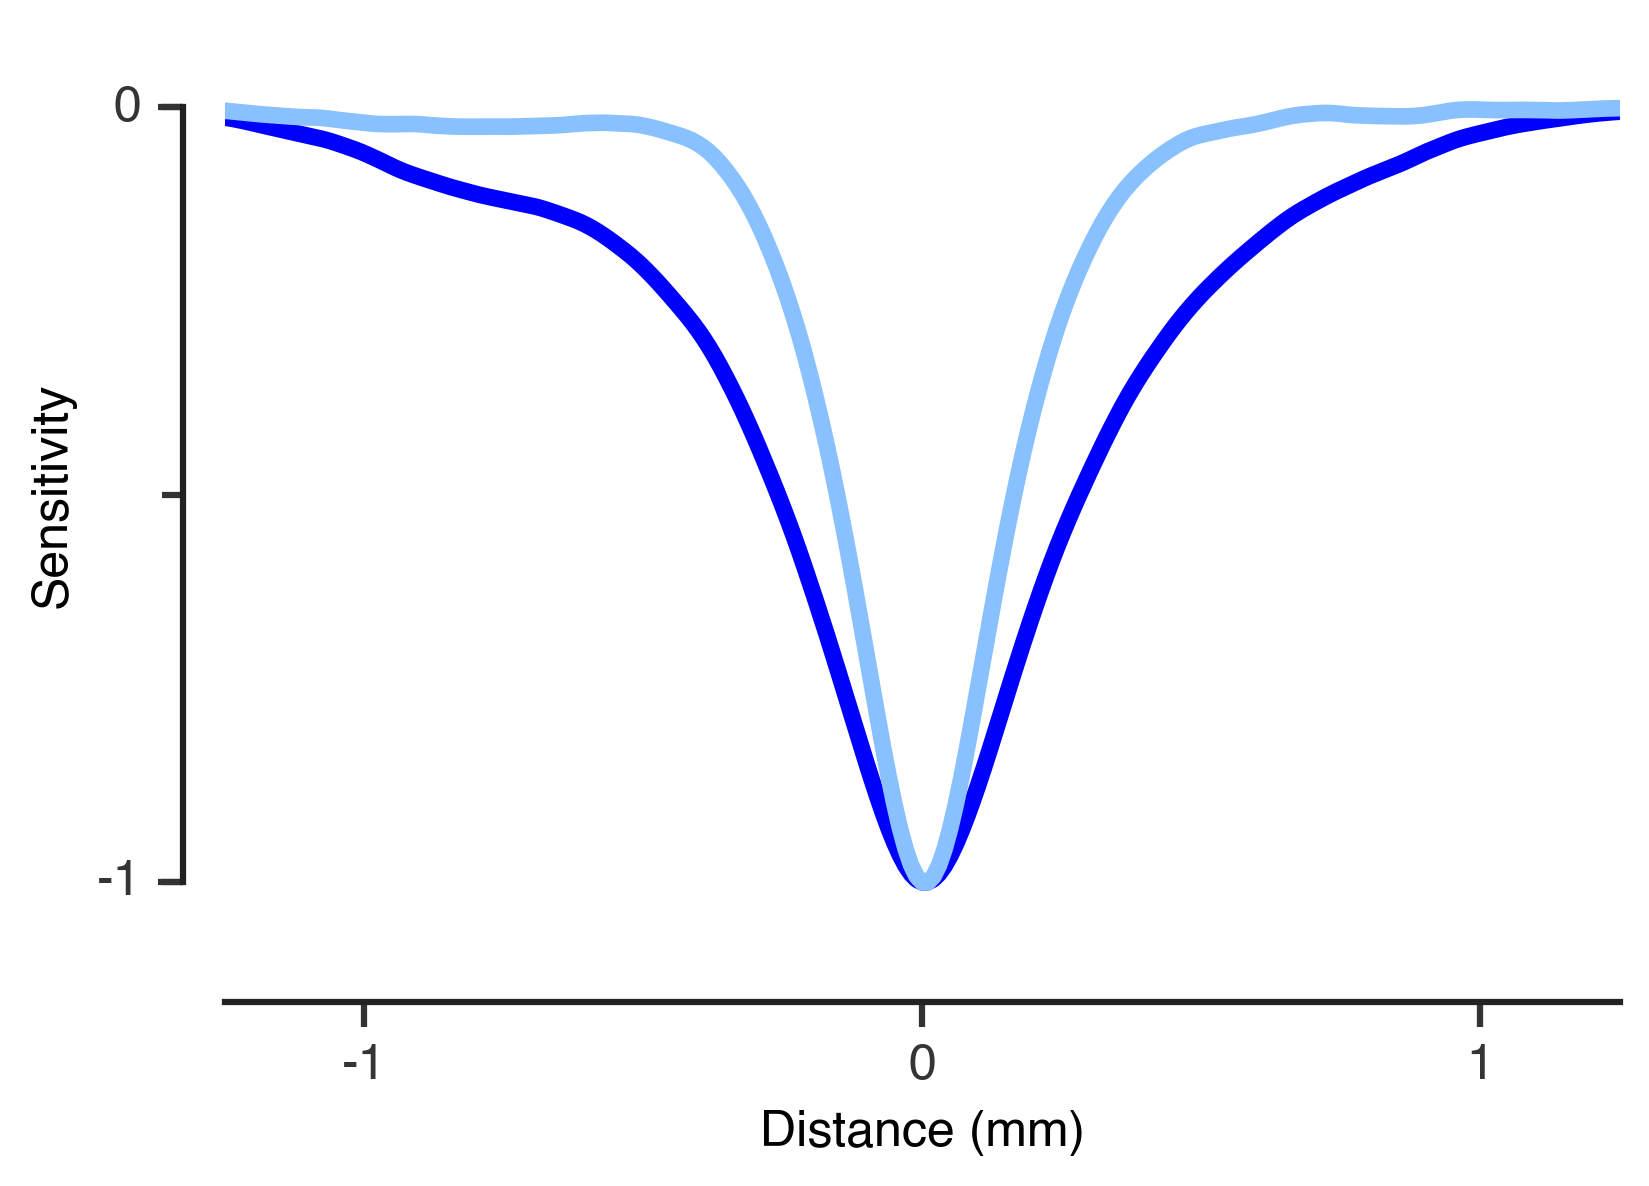

In [176]:
ganglion_surround = np.mean(surrounds['ganglion'], axis=0)
# ganglion_surround = surrounds['ganglion'][9]


plt.plot(space*microns_per_degree/1000., -ganglion_surround/np.max(abs(ganglion_surround)), color='#0000FE', linewidth=4)
plt.plot(space*microns_per_degree/1000., -ama_pf/np.max(abs(ama_pf)), color='#89C0FE', linewidth=4)
# plt.plot(space, ama_surround/np.max(abs(ama_surround)), color='#0000FE', linewidth=4)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-1.1,0.1)
plt.xlim(common_x_start, common_x_end)
plt.xlabel('Distance (mm)')
adjust_spines(plt.gca())

### Example plots with a single ganglion surround that has both amacrine and horizontal surround

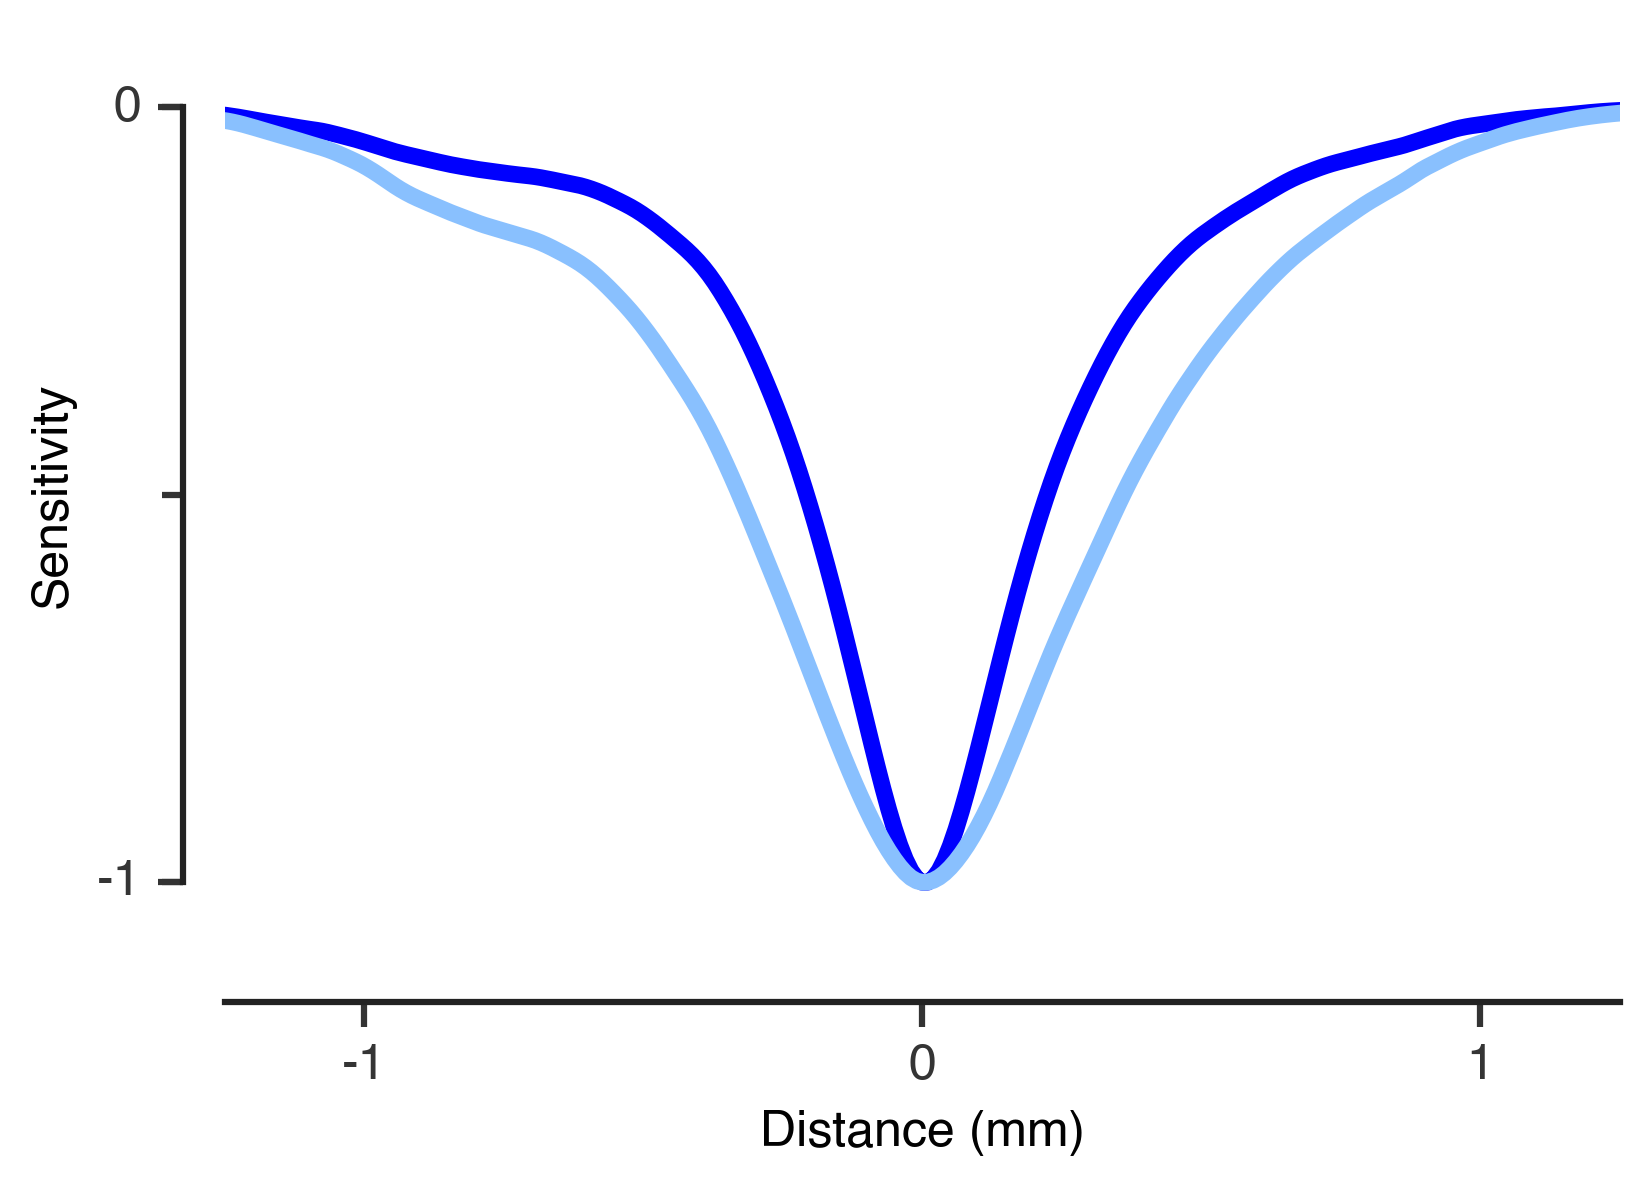

In [177]:
# ganglion_surround = np.mean(surrounds['ganglion'], axis=0)
ganglion_surround = surrounds['ganglion'][9]


plt.plot(space*microns_per_degree/1000., -ganglion_surround/np.max(abs(ganglion_surround)), color='#0000FE', linewidth=4)
plt.plot(space*microns_per_degree/1000., -horz_pf/np.max(abs(horz_pf)), color='#89C0FE', linewidth=4)
# plt.plot(space, ama_surround/np.max(abs(ama_surround)), color='#0000FE', linewidth=4)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

plt.ylim(-1.1,0.1)
plt.xlim(common_x_start, common_x_end)
plt.xlabel('Distance (mm)')
adjust_spines(plt.gca())

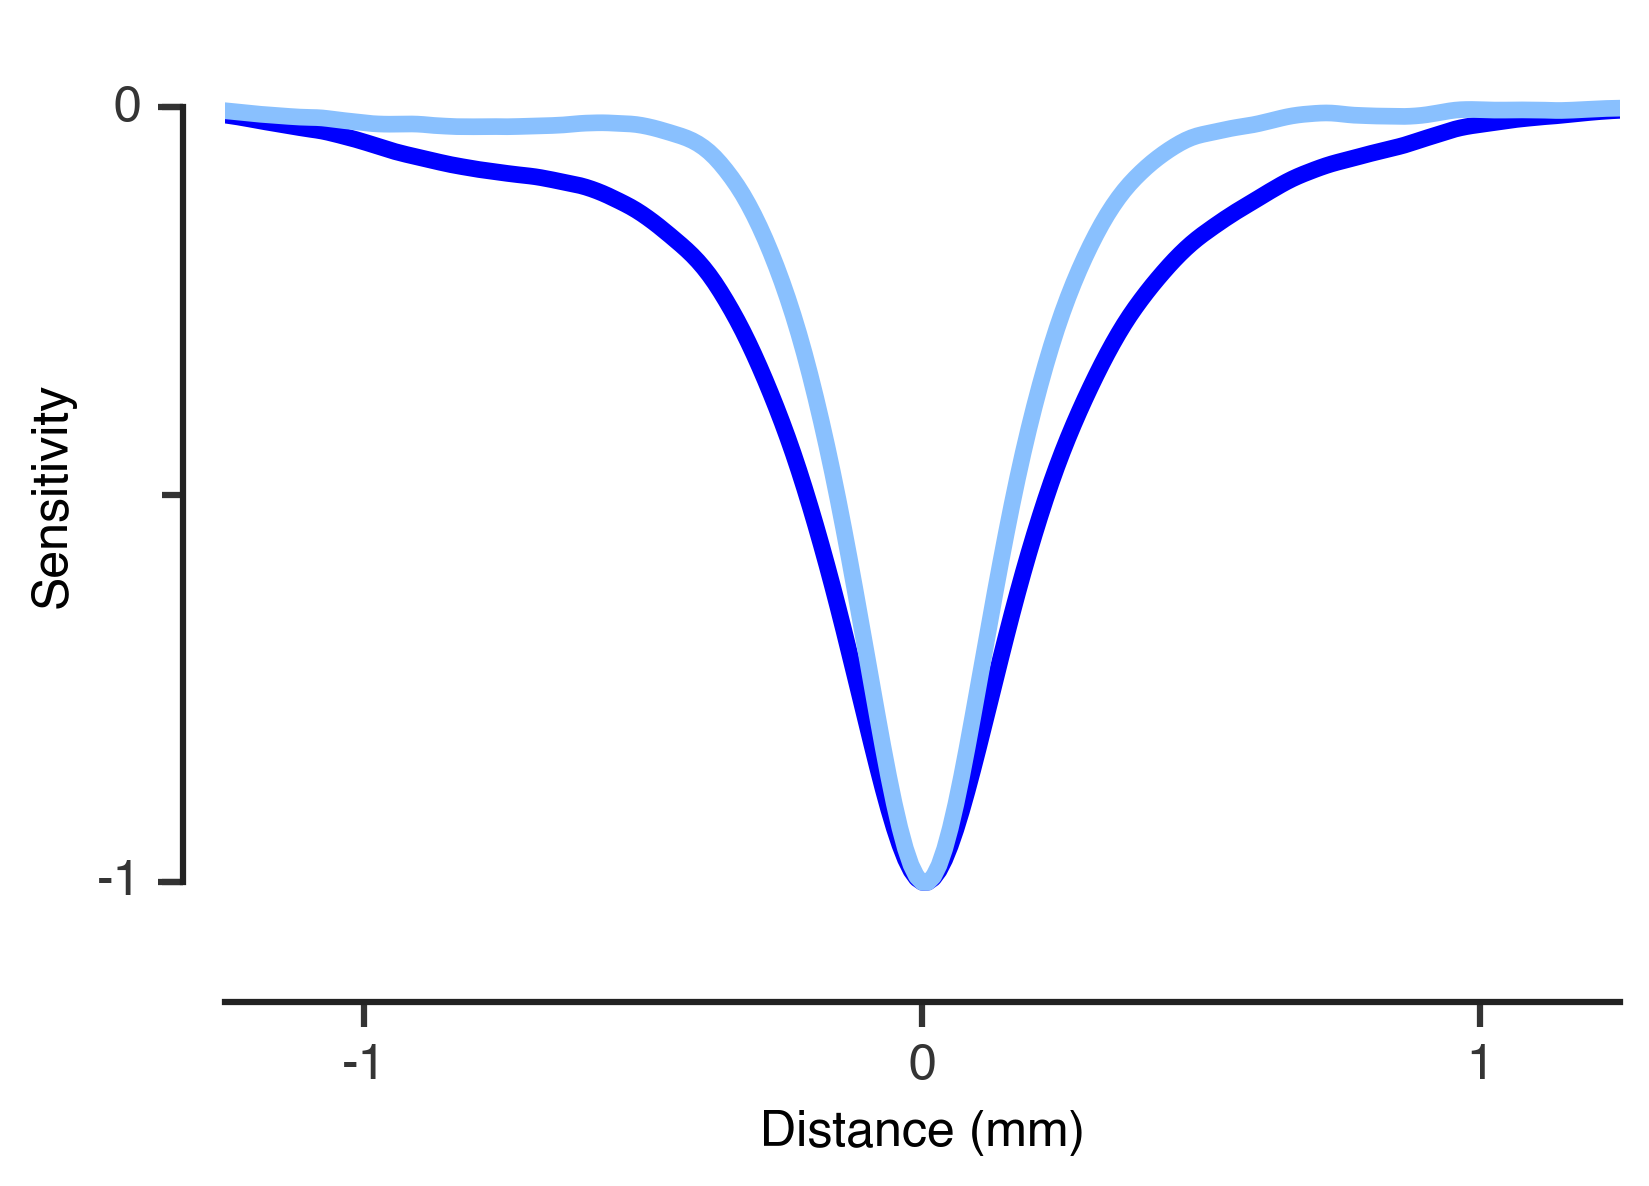

In [178]:
# ganglion_surround = np.mean(surrounds['ganglion'], axis=0)
ganglion_surround = surrounds['ganglion'][9]


plt.plot(space*microns_per_degree/1000., -ganglion_surround/np.max(abs(ganglion_surround)), color='#0000FE', linewidth=4)
plt.plot(space*microns_per_degree/1000., -ama_pf/np.max(abs(ama_pf)), color='#89C0FE', linewidth=4)
# plt.plot(space, ama_surround/np.max(abs(ama_surround)), color='#0000FE', linewidth=4)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)

plt.ylim(-1.1,0.1)
plt.xlim(common_x_start, common_x_end)
plt.xlabel('Distance (mm)')
adjust_spines(plt.gca())
plt.savefig('amacrine and ganglion surrounds - example 9.png', )

#### Try plotting all ganglion surrounds

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


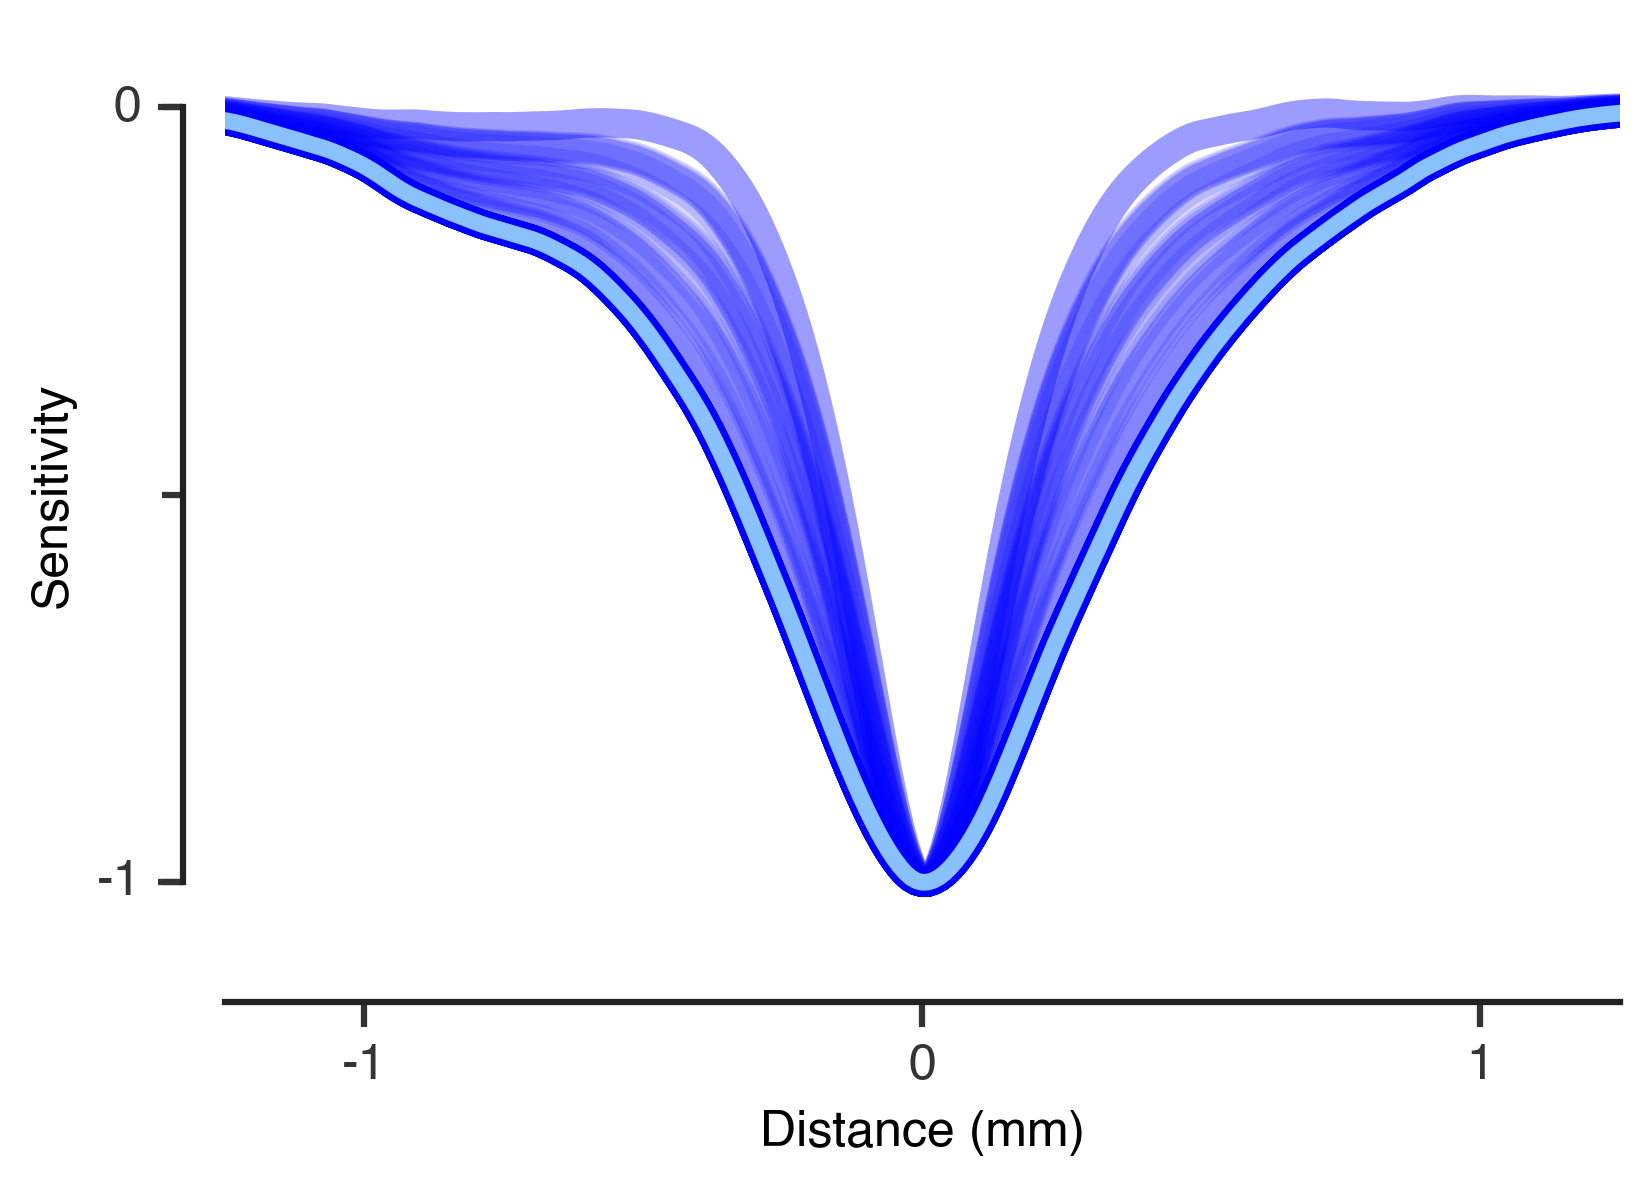

In [359]:
# ganglion_surround = np.mean(surrounds['ganglion'], axis=0)
# ganglion_surround = surrounds['ganglion'][9]

for ganglion_surround in surrounds['ganglion']:
    plt.plot(space*microns_per_degree/1000., -ganglion_surround/np.max(abs(ganglion_surround)), color='#0000FE', 
             linewidth=7, alpha=0.15)
plt.plot(space*microns_per_degree/1000., -horz_pf/np.max(abs(horz_pf)), color='#89C0FE', linewidth=4)
# plt.plot(space, ama_surround/np.max(abs(ama_surround)), color='#0000FE', linewidth=4)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-1.1,0.1)
plt.xlim(common_x_start, common_x_end)
plt.xlabel('Distance (mm)')
adjust_spines(plt.gca())
plt.savefig('horizontal pop pred with all ganglion surrounds.png', transparent=True)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


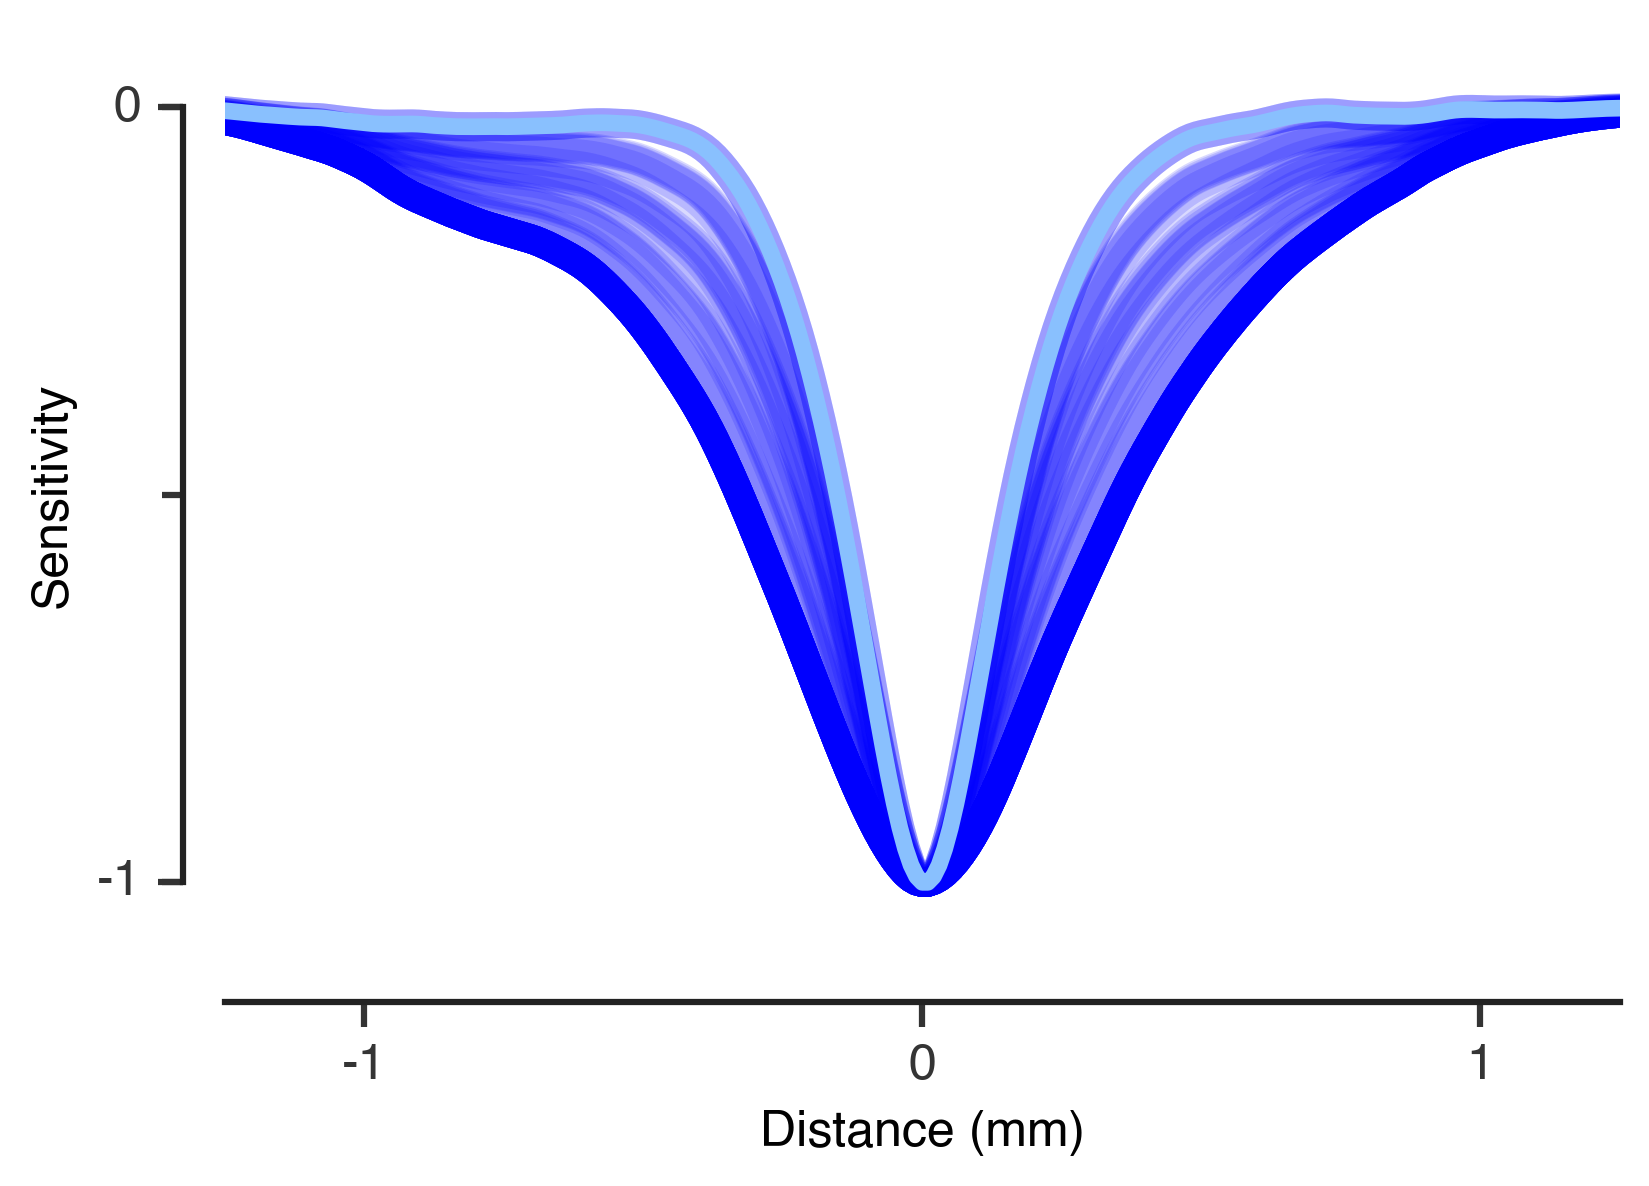

In [358]:
# ganglion_surround = np.mean(surrounds['ganglion'], axis=0)
# ganglion_surround = surrounds['ganglion'][9]

for ganglion_surround in surrounds['ganglion']:
    plt.plot(space*microns_per_degree/1000., -ganglion_surround/np.max(abs(ganglion_surround)), color='#0000FE', 
             linewidth=7, alpha=0.15)
plt.plot(space*microns_per_degree/1000., -ama_pf/np.max(abs(ama_pf)), color='#89C0FE', linewidth=4)
# plt.plot(space, ama_surround/np.max(abs(ama_surround)), color='#0000FE', linewidth=4)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-1.1,0.1)
plt.xlim(common_x_start, common_x_end)
plt.xlabel('Distance (mm)')
adjust_spines(plt.gca())
plt.savefig('amacrine pop pred with all ganglion surrounds.png', transparent=True)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


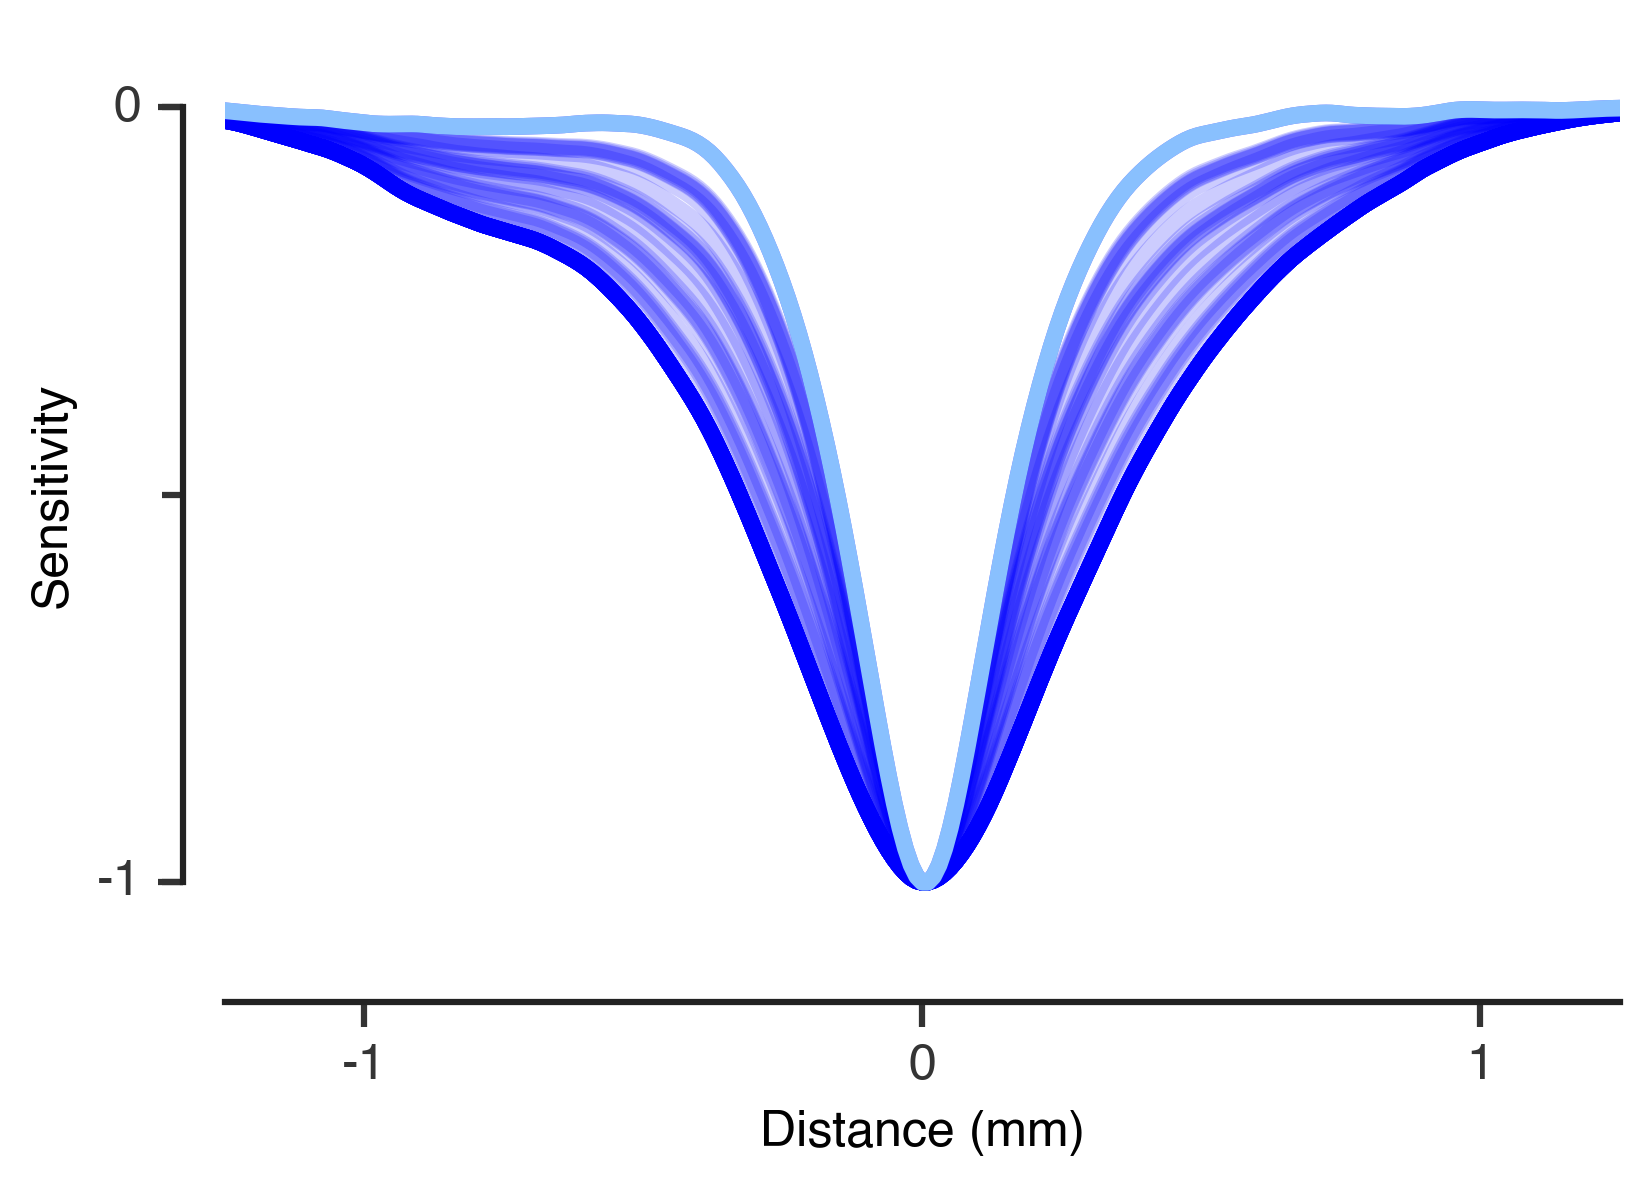

In [326]:
# ganglion_surround = np.mean(surrounds['ganglion'], axis=0)
# ganglion_surround = surrounds['ganglion'][9]

tmp = []
for ganglion_surround in surrounds['ganglion']:
    if np.sum([np.array_equal(ganglion_surround.astype('float16'), t) for t in tmp]) < 1:
        plt.plot(space*microns_per_degree/1000., -ganglion_surround/np.max(abs(ganglion_surround)), color='#0000FE', 
                 linewidth=4, alpha=0.2)
        tmp.append(ganglion_surround.astype('float16'))
plt.plot(space*microns_per_degree/1000., -ama_pf/np.max(abs(ama_pf)), color='#89C0FE', linewidth=4)
# plt.plot(space, ama_surround/np.max(abs(ama_surround)), color='#0000FE', linewidth=4)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-1.1,0.1)
plt.xlim(common_x_start, common_x_end)
plt.xlabel('Distance (mm)')
adjust_spines(plt.gca())

In [322]:
from scipy.stats import pearsonr

In [323]:
cc_matrix = np.zeros((60,60))
for i,s1 in enumerate(surrounds['ganglion']):
    for j,s2 in enumerate(surrounds['ganglion']):
        cc_matrix[i,j] = pearsonr(s1, s2)[0]

/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:2787: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


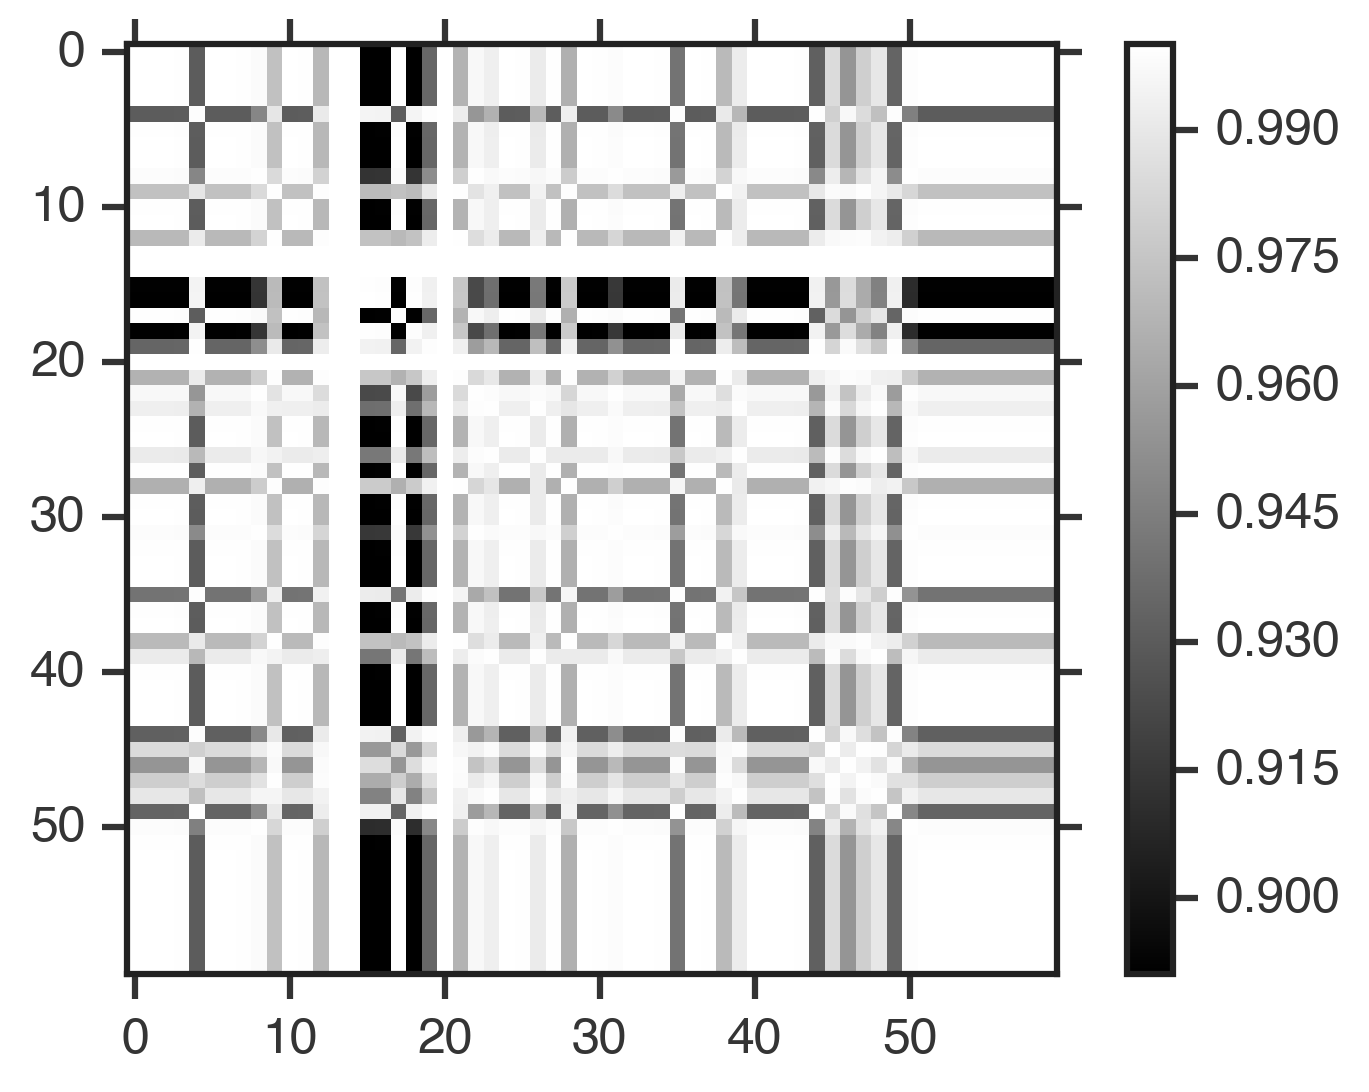

In [325]:
plt.imshow(cc_matrix)
plt.colorbar()

In [334]:
# [np.min(g) for g in surrounds['ganglion']]

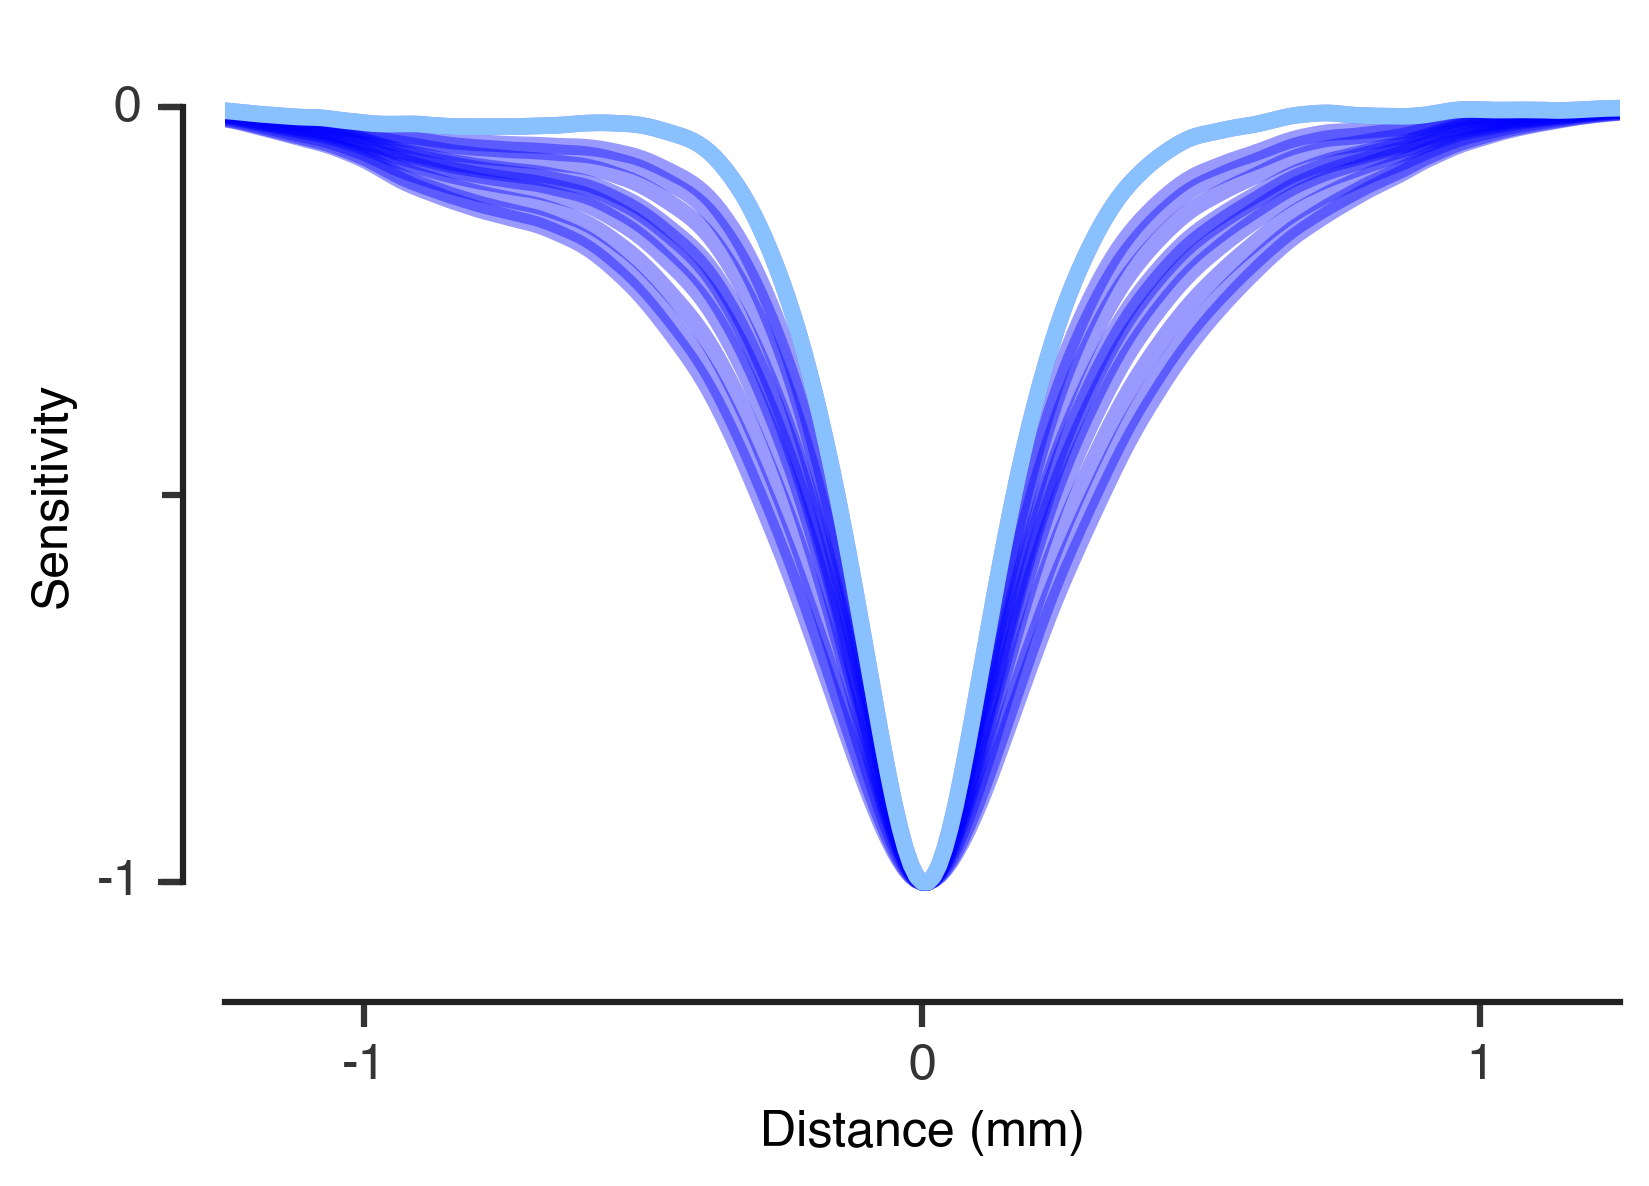

In [351]:
# ganglion_surround = np.mean(surrounds['ganglion'], axis=0)
# ganglion_surround = surrounds['ganglion'][9]

for i,ganglion_surround in enumerate(surrounds['ganglion']):
    if np.min(ganglion_surround) != 0.0:
        if i > 0:
            if np.nanmax(cc_matrix[i,:i]) < 0.9999:
                plt.plot(space*microns_per_degree/1000., -ganglion_surround/np.max(abs(ganglion_surround)), color='#0000FE', 
                         linewidth=4, alpha=0.4)
plt.plot(space*microns_per_degree/1000., -ama_pf/np.max(abs(ama_pf)), color='#89C0FE', linewidth=4)
# plt.plot(space, ama_surround/np.max(abs(ama_surround)), color='#0000FE', linewidth=4)
plt.xlabel('Distance (mm)')
plt.ylabel('Sensitivity')

majorLocator = MultipleLocator(1.0)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator)



plt.ylim(-1.1,0.1)
plt.xlim(common_x_start, common_x_end)
plt.xlabel('Distance (mm)')
adjust_spines(plt.gca())

## Quantification

#### Histogram of horizontal/amacrine weight

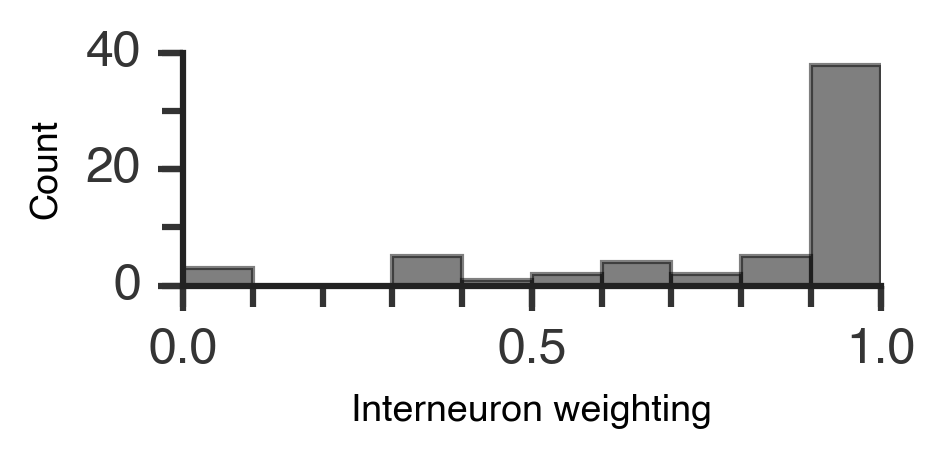

In [292]:
fig = plt.gcf()
fig.set_size_inches((3,1))

count, bins = np.histogram(fits['ganglion'][:,0], bins=10)
bin_width = np.mean(np.diff(bins))

plt.bar(bins[:-1], count, width=np.diff(bins), color='k', alpha=0.5)
plt.xlabel('Interneuron weighting', fontsize=9)
plt.ylabel('Count', fontsize=9)

majorLocator_y = MultipleLocator(20)
majorLocator_x = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%d')
minorLocator_y = MultipleLocator(10)
minorLocator_x = MultipleLocator(0.1)

ax = plt.gca()
# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator_y)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator_y)
ax.xaxis.set_major_locator(majorLocator_x)
ax.xaxis.set_minor_locator(minorLocator_x)



ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.savefig('histogram of horz and center weightings.png', transparent=True)

#### Scatter plot of horizontal weight versus surround weight

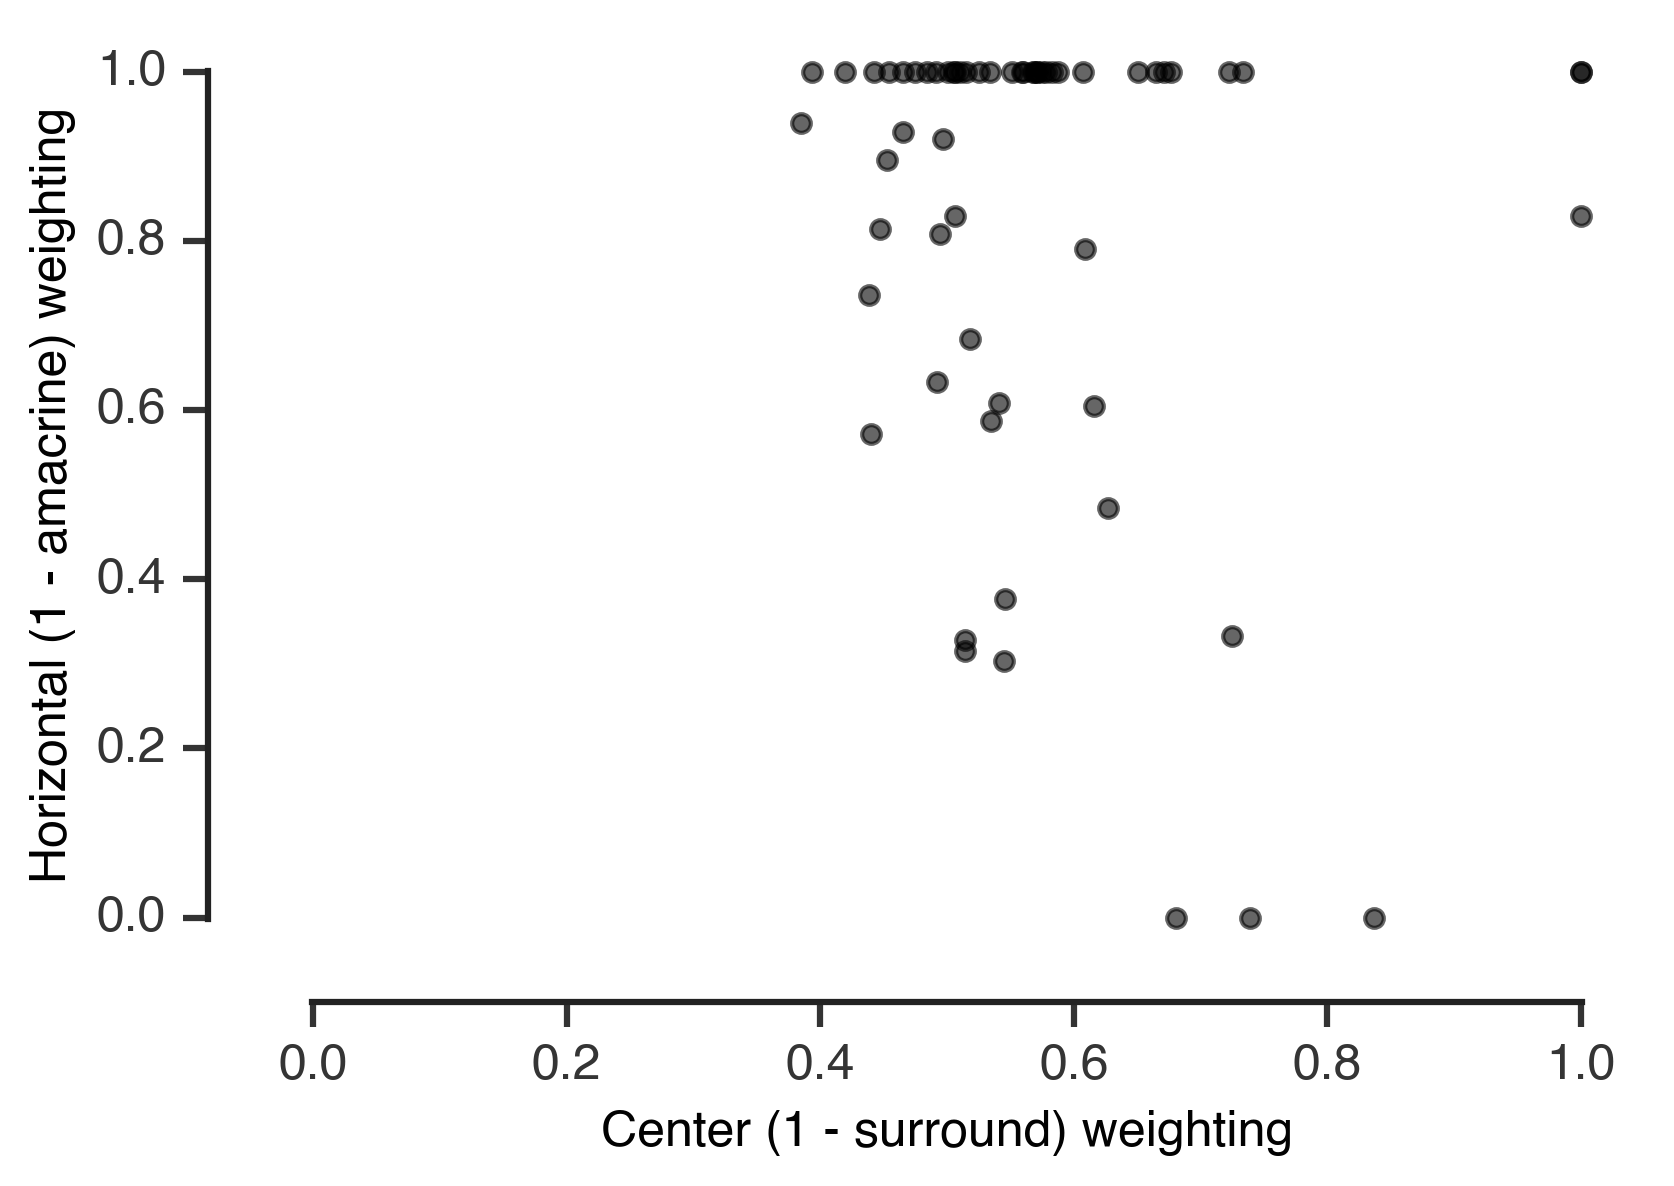

In [291]:
plt.scatter(fits[celltype][:,1], fits[celltype][:,0], c='k', alpha=0.6)
plt.scatter(0,0,c='w',edgecolor='w')
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
adjust_spines(plt.gca())
plt.ylabel('Horizontal (1 - amacrine) weighting')
plt.xlabel('Center (1 - surround) weighting')

plt.savefig('scatter plot of horz and center weightings.png', transparent=True)

## Try a histogram of horizontal and amacrine cell widths versus ganglion surround

In [198]:
ganglion_surround_fits = []
for surround in surrounds['ganglion']:
    popt, pcov = curve_fit(gaussian, space, surround, p0=[2.5, 0.0, 2.1])
    ganglion_surround_fits.append(abs(popt[0]))

/usr/local/lib/python3.4/dist-packages/scipy/optimize/minpack.py:694: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


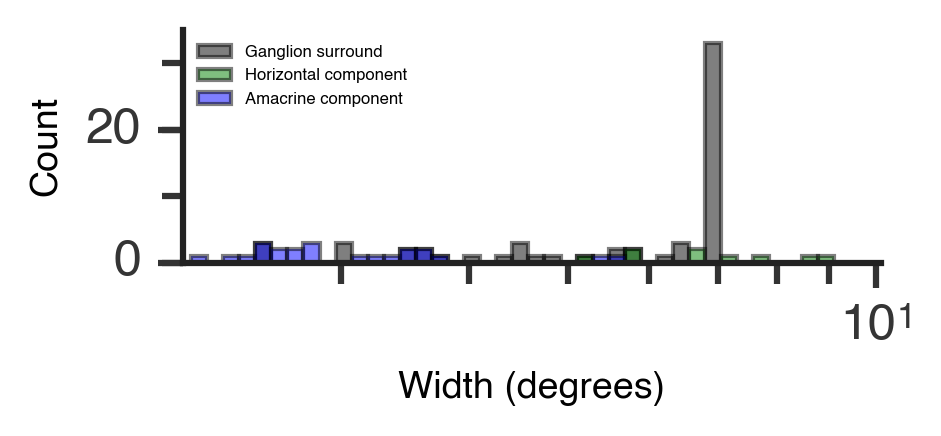

In [210]:
fig = plt.gcf()
fig.set_size_inches((3,1))

# bins = np.linspace(np.min([np.min(interneuron_fits['horizontal']),
#                           np.min(interneuron_fits['amacrine']),
#                           np.min(surround_widths['ganglion'])]),
#                   np.max([np.max(interneuron_fits['horizontal']),
#                           np.max(interneuron_fits['amacrine']),
#                           np.max(surround_widths['ganglion'])]), 20)
bins = np.logspace(0.33, 1.1)

count_ganglion, bins = np.histogram(ganglion_surround_fits, bins=bins)
count_horz, bins = np.histogram(interneuron_fits['horizontal'], bins=bins)
count_ama, bins = np.histogram(interneuron_fits['amacrine'], bins=bins)
bin_width = np.mean(np.diff(bins))

plt.bar(bins[:-1], count_ganglion, width=np.diff(bins), color='k', alpha=0.5, label='Ganglion surround')
plt.bar(bins[:-1], count_horz, width=np.diff(bins), color='g', alpha=0.5, label='Horizontal component')
plt.bar(bins[:-1], count_ama, width=np.diff(bins), color='b', alpha=0.5, label='Amacrine component')
plt.legend(loc='upper left', frameon=False, fontsize=4)
plt.xlabel('Width (degrees)', fontsize=9)
plt.ylabel('Count', fontsize=9)
plt.xscale('log')
# plt.yscale('log')
plt.xlim([2.1, 10.1])

majorLocator_y = MultipleLocator(20)
majorLocator_x = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%d')
minorLocator_y = MultipleLocator(10)
minorLocator_x = MultipleLocator(0.1)

ax = plt.gca()
# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator_y)
ax.yaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_minor_locator(minorLocator_y)
# ax.xaxis.set_major_locator(majorLocator_x)
# ax.xaxis.set_minor_locator(minorLocator_x)


ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')

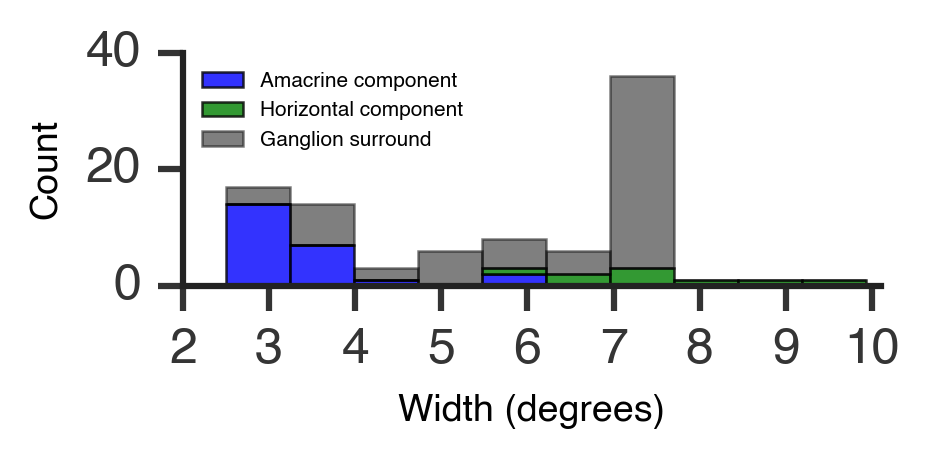

In [231]:
fig = plt.gcf()
fig.set_size_inches((3,1))

bins = np.linspace(np.min([np.min(interneuron_fits['horizontal']),
                          np.min(interneuron_fits['amacrine']),
                          np.min(surround_widths['ganglion'])]),
                  np.max([np.max(interneuron_fits['horizontal']),
                          np.max(interneuron_fits['amacrine']),
                          np.max(surround_widths['ganglion'])]), 15)

count_ganglion, bins = np.histogram(ganglion_surround_fits, bins=bins)
count_horz, bins = np.histogram(interneuron_fits['horizontal'], bins=bins)
count_ama, bins = np.histogram(interneuron_fits['amacrine'], bins=bins)
bin_width = np.mean(np.diff(bins))

plt.bar(bins[:-1] + bin_width/2, count_ama, width=np.diff(bins), color='#0000FE', alpha=0.8, 
        linewidth=0.6, label='Amacrine component')
plt.bar(bins[:-1] + bin_width/2, count_horz, bottom=count_ama, width=np.diff(bins), color='g', alpha=0.8, 
        linewidth=0.6, label='Horizontal component')
plt.bar(bins[:-1] + bin_width/2, count_ganglion, bottom=count_horz+count_ama, width=np.diff(bins), color='k', 
        alpha=0.5, linewidth=0.6, label='Ganglion surround')
plt.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlabel('Width (degrees)', fontsize=9)
plt.ylabel('Count', fontsize=9)
plt.xlim([2, 10.1])

majorLocator_y = MultipleLocator(20)
majorLocator_x = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%d')
minorLocator_y = MultipleLocator(10)
minorLocator_x = MultipleLocator(0.1)

ax = plt.gca()
# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator_y)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator_y)
# ax.xaxis.set_major_locator(majorLocator_x)
# ax.xaxis.set_minor_locator(minorLocator_x)


ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())

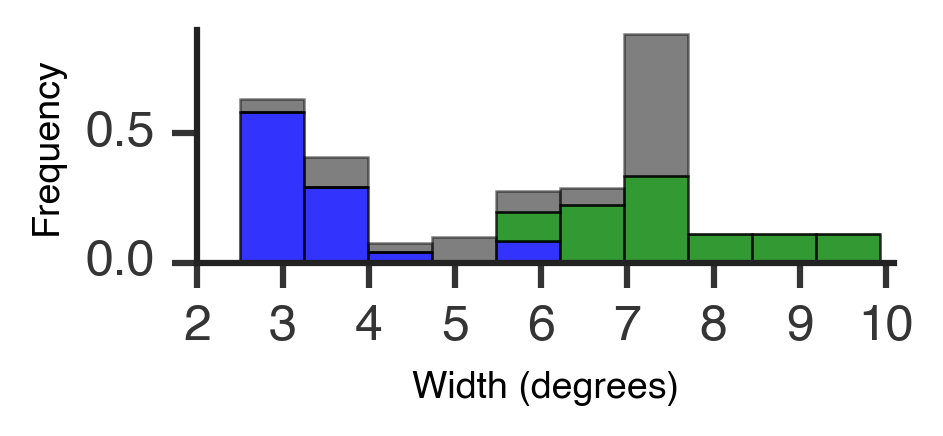

In [290]:
fig = plt.gcf()
fig.set_size_inches((3,1))

bins = np.linspace(np.min([np.min(interneuron_fits['horizontal']),
                          np.min(interneuron_fits['amacrine']),
                          np.min(surround_widths['ganglion'])]),
                  np.max([np.max(interneuron_fits['horizontal']),
                          np.max(interneuron_fits['amacrine']),
                          np.max(surround_widths['ganglion'])]), 15)

count_ganglion, bins = np.histogram(ganglion_surround_fits, bins=bins, density=True)
count_horz, bins = np.histogram(interneuron_fits['horizontal'], bins=bins, density=True)
count_ama, bins = np.histogram(interneuron_fits['amacrine'], bins=bins, density=True)
bin_width = np.mean(np.diff(bins))

count_ganglion /= np.sum(count_ganglion)
count_horz /= np.sum(count_horz)
count_ama /= np.sum(count_ama)

plt.bar(bins[:-1] + bin_width/2, count_ama, width=np.diff(bins), color='#0000FE', alpha=0.8, 
        linewidth=0.6, label='Amacrine component')
plt.bar(bins[:-1] + bin_width/2, count_horz, bottom=count_ama, width=np.diff(bins), color='g', alpha=0.8, 
        linewidth=0.6, label='Horizontal component')
plt.bar(bins[:-1] + bin_width/2, count_ganglion, bottom=count_horz+count_ama, width=np.diff(bins), color='k', 
        alpha=0.5, linewidth=0.6, label='Ganglion surround')
# plt.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlabel('Width (degrees)', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
plt.xlim([2, 10.1])

majorLocator_y = MultipleLocator(0.5)
majorLocator_x = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator_y = MultipleLocator(10)
minorLocator_x = MultipleLocator(0.1)

ax = plt.gca()
# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator_y)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator_y)
# ax.xaxis.set_major_locator(majorLocator_x)
# ax.xaxis.set_minor_locator(minorLocator_x)


ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())

plt.savefig('width stacked histogram for horz, ama, ganglion cells.png', transparent=True)

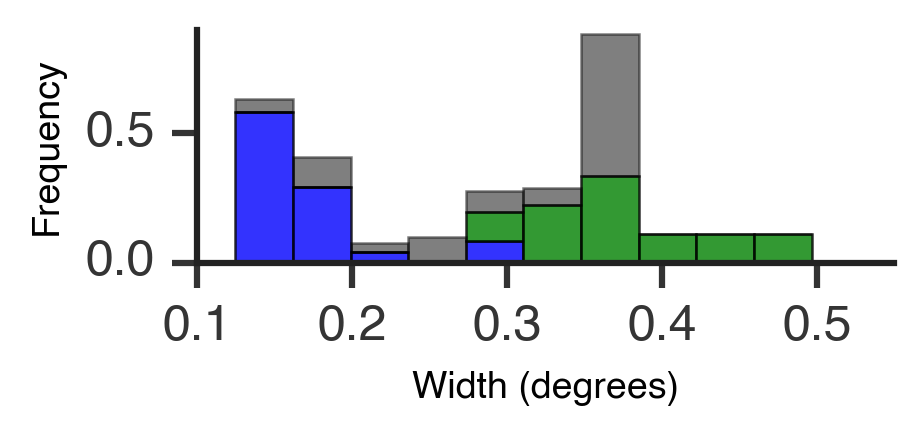

In [289]:
fig = plt.gcf()
fig.set_size_inches((3,1))

bins = np.linspace(np.min([np.min(interneuron_fits['horizontal']),
                          np.min(interneuron_fits['amacrine']),
                          np.min(surround_widths['ganglion'])]),
                  np.max([np.max(interneuron_fits['horizontal']),
                          np.max(interneuron_fits['amacrine']),
                          np.max(surround_widths['ganglion'])]), 15)

bins *= microns_per_degree/1000.

count_ganglion, bins = np.histogram(np.array(ganglion_surround_fits)*microns_per_degree/1000., bins=bins, density=True)
count_horz, bins = np.histogram(np.array(interneuron_fits['horizontal'])*microns_per_degree/1000., bins=bins, density=True)
count_ama, bins = np.histogram(np.array(interneuron_fits['amacrine'])*microns_per_degree/1000., bins=bins, density=True)
bin_width = np.mean(np.diff(bins))

count_ganglion /= np.sum(count_ganglion)
count_horz /= np.sum(count_horz)
count_ama /= np.sum(count_ama)

plt.bar(bins[:-1] + bin_width/2, count_ama, width=np.diff(bins), color='#0000FE', alpha=0.8, 
        linewidth=0.6, label='Amacrine component')
plt.bar(bins[:-1] + bin_width/2, count_horz, bottom=count_ama, width=np.diff(bins), color='g', alpha=0.8, 
        linewidth=0.6, label='Horizontal component')
plt.bar(bins[:-1] + bin_width/2, count_ganglion, bottom=count_horz+count_ama, width=np.diff(bins), color='k', 
        alpha=0.5, linewidth=0.6, label='Ganglion surround')
# plt.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlabel('Width (degrees)', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
plt.xlim([0.1, 0.55])

majorLocator_y = MultipleLocator(0.5)
majorLocator_x = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator_y = MultipleLocator(10)
minorLocator_x = MultipleLocator(0.1)

ax = plt.gca()
# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator_y)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator_y)
# ax.xaxis.set_major_locator(majorLocator_x)
# ax.xaxis.set_minor_locator(minorLocator_x)


ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())

plt.savefig('width stacked histogram mm for horz, ama, ganglion cells.png', transparent=True)

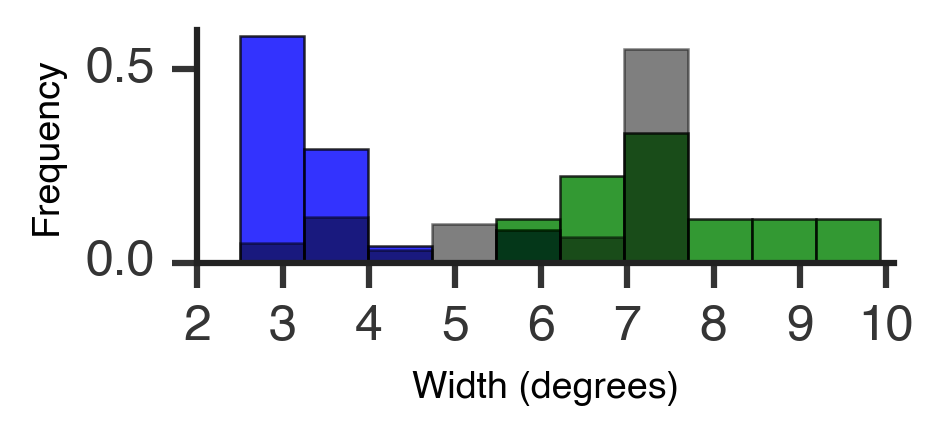

In [252]:
fig = plt.gcf()
fig.set_size_inches((3,1))

bins = np.linspace(np.min([np.min(interneuron_fits['horizontal']),
                          np.min(interneuron_fits['amacrine']),
                          np.min(surround_widths['ganglion'])]),
                  np.max([np.max(interneuron_fits['horizontal']),
                          np.max(interneuron_fits['amacrine']),
                          np.max(surround_widths['ganglion'])]), 15)

count_ganglion, bins = np.histogram(ganglion_surround_fits, bins=bins, density=True)
count_horz, bins = np.histogram(interneuron_fits['horizontal'], bins=bins, density=True)
count_ama, bins = np.histogram(interneuron_fits['amacrine'], bins=bins, density=True)
bin_width = np.mean(np.diff(bins))

count_ganglion /= np.sum(count_ganglion)
count_horz /= np.sum(count_horz)
count_ama /= np.sum(count_ama)

plt.bar(bins[:-1] + bin_width/2, count_ama, width=np.diff(bins), color='#0000FE', alpha=0.8, 
        linewidth=0.6, label='Amacrine component')
plt.bar(bins[:-1] + bin_width/2, count_horz, width=np.diff(bins), color='g', alpha=0.8, 
        linewidth=0.6, label='Horizontal component')
plt.bar(bins[:-1] + bin_width/2, count_ganglion, width=np.diff(bins), color='k', 
        alpha=0.5, linewidth=0.6, label='Ganglion surround')
# plt.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlabel('Width (degrees)', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
plt.xlim([2, 10.1])

majorLocator_y = MultipleLocator(0.5)
majorLocator_x = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator_y = MultipleLocator(10)
minorLocator_x = MultipleLocator(0.1)

ax = plt.gca()
# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator_y)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator_y)
# ax.xaxis.set_major_locator(majorLocator_x)
# ax.xaxis.set_minor_locator(minorLocator_x)


ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())

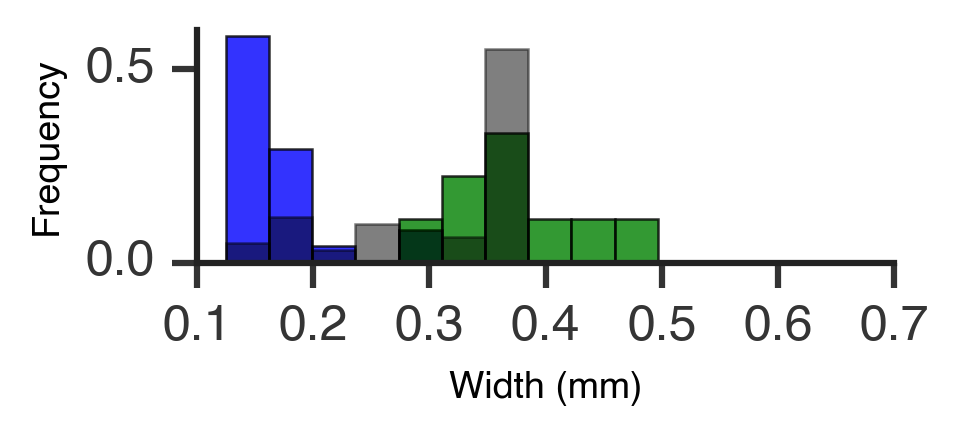

In [284]:
fig = plt.gcf()
fig.set_size_inches((3,1))

bins = np.linspace(np.min([np.min(interneuron_fits['horizontal']),
                          np.min(interneuron_fits['amacrine']),
                          np.min(surround_widths['ganglion'])]),
                  np.max([np.max(interneuron_fits['horizontal']),
                          np.max(interneuron_fits['amacrine']),
                          np.max(surround_widths['ganglion'])]), 15)

bins *= microns_per_degree/1000.

count_ganglion, bins = np.histogram(np.array(ganglion_surround_fits)*microns_per_degree/1000., bins=bins, density=True)
count_horz, bins = np.histogram(np.array(interneuron_fits['horizontal'])*microns_per_degree/1000., bins=bins, density=True)
count_ama, bins = np.histogram(np.array(interneuron_fits['amacrine'])*microns_per_degree/1000., bins=bins, density=True)
bin_width = np.mean(np.diff(bins))

count_ganglion /= np.sum(count_ganglion)
count_horz /= np.sum(count_horz)
count_ama /= np.sum(count_ama)

plt.bar(bins[:-1] + bin_width/2, count_ama, width=np.diff(bins), color='#0000FE', alpha=0.8, 
        linewidth=0.6, label='Amacrine component')
plt.bar(bins[:-1] + bin_width/2, count_horz, width=np.diff(bins), color='g', alpha=0.8, 
        linewidth=0.6, label='Horizontal component')
plt.bar(bins[:-1] + bin_width/2, count_ganglion, width=np.diff(bins), color='k', 
        alpha=0.5, linewidth=0.6, label='Ganglion surround')
# plt.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlabel('Width (mm)', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
# plt.xlim([2, 10.1])

majorLocator_y = MultipleLocator(0.5)
majorLocator_x = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator_y = MultipleLocator(10)
minorLocator_x = MultipleLocator(0.1)

ax = plt.gca()
# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator_y)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator_y)
# ax.xaxis.set_major_locator(majorLocator_x)
# ax.xaxis.set_minor_locator(minorLocator_x)


ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())

plt.savefig('width histogram for horz, ama, ganglion cells.png', transparent=True)

In [249]:
count_ganglion

array([  1.34475464,   3.13776083,   0.89650309,   2.68950928,
         2.24125774,   1.79300619,  14.79230106,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])

### A plot like in Fig 1 G

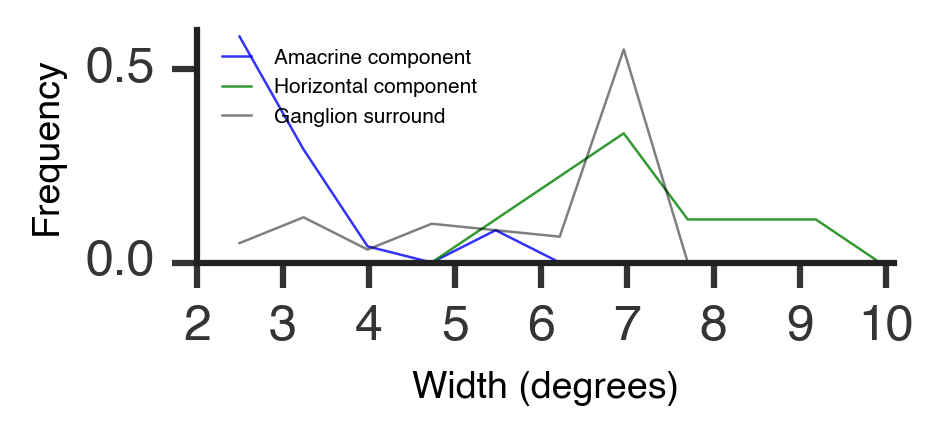

In [255]:
fig = plt.gcf()
fig.set_size_inches((3,1))

bins = np.linspace(np.min([np.min(interneuron_fits['horizontal']),
                          np.min(interneuron_fits['amacrine']),
                          np.min(surround_widths['ganglion'])]),
                  np.max([np.max(interneuron_fits['horizontal']),
                          np.max(interneuron_fits['amacrine']),
                          np.max(surround_widths['ganglion'])]), 15)

count_ganglion, bins = np.histogram(ganglion_surround_fits, bins=bins, density=True)
count_horz, bins = np.histogram(interneuron_fits['horizontal'], bins=bins, density=True)
count_ama, bins = np.histogram(interneuron_fits['amacrine'], bins=bins, density=True)
bin_width = np.mean(np.diff(bins))

count_ganglion /= np.sum(count_ganglion)
count_horz /= np.sum(count_horz)
count_ama /= np.sum(count_ama)

plt.plot(bins[:-1] + bin_width/2, count_ama, color='#0000FE', alpha=0.8, 
        linewidth=0.6, label='Amacrine component')
plt.plot(bins[:-1] + bin_width/2, count_horz, color='g', alpha=0.8, 
        linewidth=0.6, label='Horizontal component')
plt.plot(bins[:-1] + bin_width/2, count_ganglion, color='k', 
        alpha=0.5, linewidth=0.6, label='Ganglion surround')
plt.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlabel('Width (degrees)', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
plt.xlim([2, 10.1])

majorLocator_y = MultipleLocator(0.5)
majorLocator_x = MultipleLocator(0.5)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator_y = MultipleLocator(10)
minorLocator_x = MultipleLocator(0.1)

ax = plt.gca()
# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator_y)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator_y)
# ax.xaxis.set_major_locator(majorLocator_x)
# ax.xaxis.set_minor_locator(minorLocator_x)


ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())

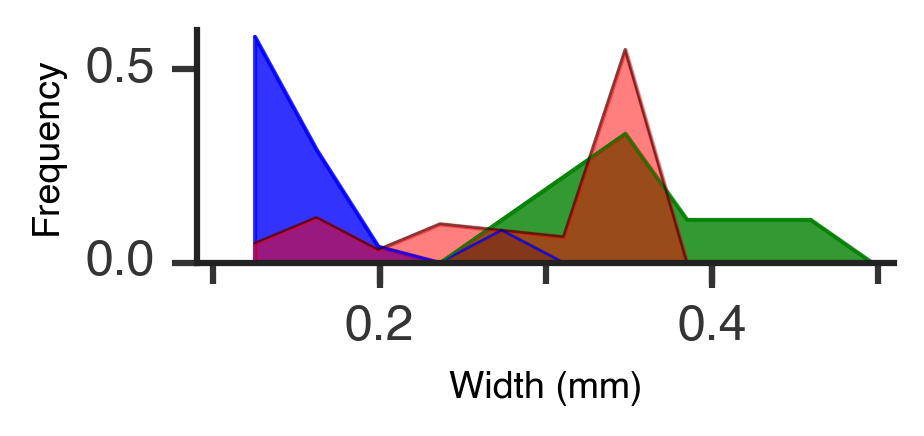

In [283]:
fig = plt.gcf()
fig.set_size_inches((3,1))

bins = np.linspace(np.min([np.min(interneuron_fits['horizontal']),
                          np.min(interneuron_fits['amacrine']),
                          np.min(surround_widths['ganglion'])]),
                  np.max([np.max(interneuron_fits['horizontal']),
                          np.max(interneuron_fits['amacrine']),
                          np.max(surround_widths['ganglion'])]), 15)

bins *= microns_per_degree/1000.

count_ganglion, bins = np.histogram(np.array(ganglion_surround_fits)*microns_per_degree/1000., bins=bins, density=True)
count_horz, bins = np.histogram(np.array(interneuron_fits['horizontal'])*microns_per_degree/1000., bins=bins, density=True)
count_ama, bins = np.histogram(np.array(interneuron_fits['amacrine'])*microns_per_degree/1000., bins=bins, density=True)
bin_width = np.mean(np.diff(bins))

count_ganglion /= np.sum(count_ganglion)
count_horz /= np.sum(count_horz)
count_ama /= np.sum(count_ama)

plt.plot(bins[:-1] + bin_width/2, count_ama, color='#0000FE', alpha=0.8, 
        linewidth=0.6, label='Amacrine component')
plt.plot(bins[:-1] + bin_width/2, count_horz, color='g', alpha=0.8, 
        linewidth=0.6, label='Horizontal component')
plt.plot(bins[:-1] + bin_width/2, count_ganglion, color='k', 
        alpha=0.5, linewidth=0.6, label='Ganglion surround')

plt.fill_between(bins[:-1] + bin_width/2, 0, count_ama, color='#0000FE', alpha=0.8)
plt.fill_between(bins[:-1] + bin_width/2, 0, count_horz, color='g', alpha=0.8)
plt.fill_between(bins[:-1] + bin_width/2, 0, count_ganglion, color='r', alpha=0.5)

# plt.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlabel('Width (mm)', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
# plt.xlim([2, 10.1])
# plt.xlim(common_x_start, common_x_end)
# plt.xlim(0.09, 0.6005)
plt.xlim(0.09, 0.51)

majorLocator_y = MultipleLocator(0.5)
majorLocator_x = MultipleLocator(0.2)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator_y = MultipleLocator(10)
minorLocator_x = MultipleLocator(0.1)

ax = plt.gca()
# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator_y)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator_y)
ax.xaxis.set_major_locator(majorLocator_x)
ax.xaxis.set_minor_locator(minorLocator_x)


ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())

plt.savefig('width plot-like histogram for horz, ama, red ganglion cells.png', transparent=True)

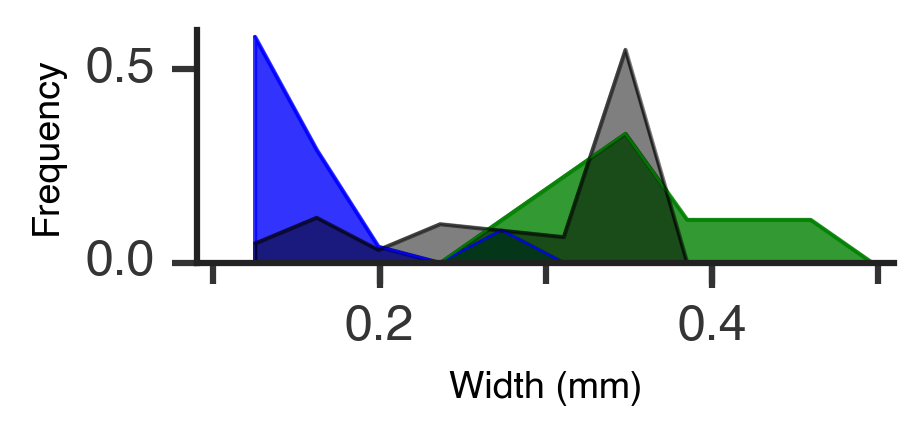

In [282]:
fig = plt.gcf()
fig.set_size_inches((3,1))

bins = np.linspace(np.min([np.min(interneuron_fits['horizontal']),
                          np.min(interneuron_fits['amacrine']),
                          np.min(surround_widths['ganglion'])]),
                  np.max([np.max(interneuron_fits['horizontal']),
                          np.max(interneuron_fits['amacrine']),
                          np.max(surround_widths['ganglion'])]), 15)

bins *= microns_per_degree/1000.

count_ganglion, bins = np.histogram(np.array(ganglion_surround_fits)*microns_per_degree/1000., bins=bins, density=True)
count_horz, bins = np.histogram(np.array(interneuron_fits['horizontal'])*microns_per_degree/1000., bins=bins, density=True)
count_ama, bins = np.histogram(np.array(interneuron_fits['amacrine'])*microns_per_degree/1000., bins=bins, density=True)
bin_width = np.mean(np.diff(bins))

count_ganglion /= np.sum(count_ganglion)
count_horz /= np.sum(count_horz)
count_ama /= np.sum(count_ama)

plt.plot(bins[:-1] + bin_width/2, count_ama, color='#0000FE', alpha=0.8, 
        linewidth=0.6, label='Amacrine component')
plt.plot(bins[:-1] + bin_width/2, count_horz, color='g', alpha=0.8, 
        linewidth=0.6, label='Horizontal component')
plt.plot(bins[:-1] + bin_width/2, count_ganglion, color='k', 
        alpha=0.5, linewidth=0.6, label='Ganglion surround')

plt.fill_between(bins[:-1] + bin_width/2, 0, count_ama, color='#0000FE', alpha=0.8)
plt.fill_between(bins[:-1] + bin_width/2, 0, count_horz, color='g', alpha=0.8)
plt.fill_between(bins[:-1] + bin_width/2, 0, count_ganglion, color='k', alpha=0.5)

# plt.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlabel('Width (mm)', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
# plt.xlim([2, 10.1])
# plt.xlim(common_x_start, common_x_end)
# plt.xlim(0.09, 0.6005)
plt.xlim(0.09, 0.51)

majorLocator_y = MultipleLocator(0.5)
majorLocator_x = MultipleLocator(0.2)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator_y = MultipleLocator(10)
minorLocator_x = MultipleLocator(0.1)

ax = plt.gca()
# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator_y)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator_y)
ax.xaxis.set_major_locator(majorLocator_x)
ax.xaxis.set_minor_locator(minorLocator_x)


ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())

plt.savefig('width plot-like histogram for horz, ama, ganglion cells.png', transparent=True)

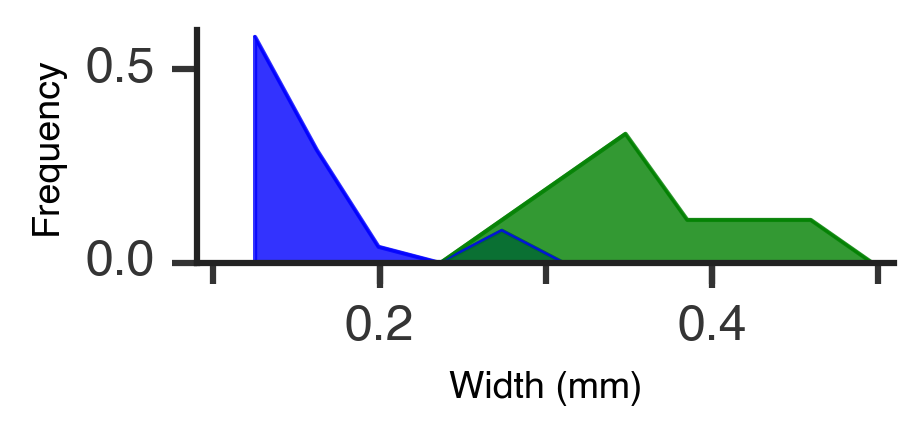

In [361]:
fig = plt.gcf()
fig.set_size_inches((3,1))

bins = np.linspace(np.min([np.min(interneuron_fits['horizontal']),
                          np.min(interneuron_fits['amacrine']),
                          np.min(surround_widths['ganglion'])]),
                  np.max([np.max(interneuron_fits['horizontal']),
                          np.max(interneuron_fits['amacrine']),
                          np.max(surround_widths['ganglion'])]), 15)

bins *= microns_per_degree/1000.

count_ganglion, bins = np.histogram(np.array(ganglion_surround_fits)*microns_per_degree/1000., bins=bins, density=True)
count_horz, bins = np.histogram(np.array(interneuron_fits['horizontal'])*microns_per_degree/1000., bins=bins, density=True)
count_ama, bins = np.histogram(np.array(interneuron_fits['amacrine'])*microns_per_degree/1000., bins=bins, density=True)
bin_width = np.mean(np.diff(bins))

count_ganglion /= np.sum(count_ganglion)
count_horz /= np.sum(count_horz)
count_ama /= np.sum(count_ama)

plt.plot(bins[:-1] + bin_width/2, count_ama, color='#0000FE', alpha=0.8, 
        linewidth=0.6, label='Amacrine component')
plt.plot(bins[:-1] + bin_width/2, count_horz, color='g', alpha=0.8, 
        linewidth=0.6, label='Horizontal component')
# plt.plot(bins[:-1] + bin_width/2, count_ganglion, color='k', 
#         alpha=0.5, linewidth=0.6, label='Ganglion surround')

plt.fill_between(bins[:-1] + bin_width/2, 0, count_ama, color='#0000FE', alpha=0.8)
plt.fill_between(bins[:-1] + bin_width/2, 0, count_horz, color='g', alpha=0.8)
# plt.fill_between(bins[:-1] + bin_width/2, 0, count_ganglion, color='k', alpha=0.5)

# plt.legend(loc='upper left', frameon=False, fontsize=5)
plt.xlabel('Width (mm)', fontsize=9)
plt.ylabel('Frequency', fontsize=9)
# plt.xlim([2, 10.1])
# plt.xlim(common_x_start, common_x_end)
# plt.xlim(0.09, 0.6005)
plt.xlim(0.09, 0.51)

majorLocator_y = MultipleLocator(0.5)
majorLocator_x = MultipleLocator(0.2)
majorFormatter = FormatStrFormatter('%0.1f')
minorLocator_y = MultipleLocator(10)
minorLocator_x = MultipleLocator(0.1)

ax = plt.gca()
# ax.xaxis.set_major_locator(majorLocator)
# ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator_y)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.yaxis.set_minor_locator(minorLocator_y)
ax.xaxis.set_major_locator(majorLocator_x)
ax.xaxis.set_minor_locator(minorLocator_x)


ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())

plt.savefig('width plot-like histogram for just horz and ama cells.png', transparent=True)

# Load transmission strength data to plot on common scale